In [1]:
%autosave 0

Autosave disabled


### Kaggle - Web Traffic Time Series Forecasting

## Model 10 - Modified CNN with Fibonacci

### v7 More Neurons

by Louis Yang

We use a Fibonacci series as the window sizes to compute the a serie of median excluding nan for each sample (page). Then find again the median amount the series excluding nan. Use this median-median (which we call Fibonacci median) as the center of each sample. The Fibonaccis serie we take is [11, 18, 30, 48, 78, 126, 203, 329], which was suggested by Ehsan https://www.kaggle.com/safavieh and has original scored 44.9 in the stage 1 leaderboard.

To better train the neural network for various scales of dayily visits, we first do the log transformation in the form 
    
    X_log = log10(X_ori + 1.0),

to bring them into the same order. Then we sample-wise standardize the data where the Fibonacci median instead of regular mean is used as the center baseline. Then we sample-wise divid the data by their standard deviation (stdev), where nan is treat as 0 in X_ori.

According to the center (Fibonacci median, fib_med), we split data into groups and train individual neural network (models) in each group. The group spliting are log10(fib_med + 1) < (1.0, 2.0, 4.0, greater). So there are total 4 groups.

The first group (group 0) use original Fibonacci median as prediction since it is difficult to learn. For other groups, we use the trained convolutional neural network (CNN) as prediction. 

The neural network takes 64 days of data and predicts the following 64 days of results. For the neural network structure, we use single 1D convolutional layer with 140 neurons, kernel size 3, and relu activation function, which pass through average pooling with size 2. After the flatten the convolutional result, we feed the Fibonacci median and stdev (after log transform) for the sample as an addional input via concatenation. Finally, the concatenated data is pass into 3 fully connected layer (130, 120, and 64 neurons) with 2 relu and 1 final linear activation functions to do the regression. 

The detail neural network structure is: 

    X > Conv1D(140, kernel=3) > AvgPool(2) > Flat > Concat > FC(130, relu) > FC(120, relu) > FC(64, linear) > Y
    Additional input (median, stdev) -------------/

Then we do ensemble learning: We train the same neural network 5 times. Each run only train on 4/5 of the data. Then we take the median of the result from each run.

We also evaluate the group models (which only train within their own group) on other groups. Based on the performance, we assign the final group model for each group. This is the group model optimization. It turns out group 3 (log10(fib_med + 1) > 4) always work better on group model 2 (2 < log10(fib_med + 1) < 4). Other groups perform best on their own group models.

This jupyter notebook can either be in test mode (test_length != 0) or prediction mode (test_length = 0). The test mode is for evaluating model performance and fine tuning model parameters. The prediction mode is for generating prediction for submission to Kaggle competition. 

v7.2 This version trains on updated stage 2 (train_3.csv) data (2015/7/1 - 2017/9/10) from the competition, and output prediction of 2017/9/11 - 2017/11/13 for the stage 2 submission.

Required input files: train_3.csv, key_2.csv

Maximum memory usage: ~6 GB (test and computing phase); ~8267 MB (writing prediction phase)

Original model: 'model_10_Modified_CNN_5_Shuffle_Ensemble_1_train3-Predict.ipynb'

In [2]:
model_name ='model_10_Modified_CNN_7_More_Neurons-Stage_2_Predict'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc  # Python garbage collect
from tools import *

## Input

In [4]:
train_file = 'train_3.csv'

In [5]:
key_file = 'key_2.csv'

In [6]:
input_df = pd.read_csv('../data/' + train_file, nrows=1)

In [7]:
input_df

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,9,22,26,...,19,33,33,18,16,27,29,23,54,38


In [8]:
input_df_dates = input_df.columns[1:]; input_df_dates

Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
       '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
       ...
       '2017-09-01', '2017-09-02', '2017-09-03', '2017-09-04', '2017-09-05',
       '2017-09-06', '2017-09-07', '2017-09-08', '2017-09-09', '2017-09-10'],
      dtype='object', length=803)

In [9]:
visits_dtype = {d: np.float32 for d in input_df_dates}

In [10]:
print('%%% Reading data '+ train_file + ' ... ', end = '', flush = True)
input_df = pd.read_csv('../data/' + train_file, engine='c', dtype=visits_dtype)
print('done!')

%%% Reading data train_3.csv ... done!


In [11]:
input_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [12]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: float32(803), object(1)
memory usage: 445.5+ MB


## Processing Data
Generate training set and test (predict) set

### Day of week alignment

In [13]:
from datetime import datetime
def weekday(datestr):
    return datetime.strptime(datestr,'%Y-%m-%d').weekday()
def daydiff(dstr1,dstr2):
    return datetime.strptime(dstr1,'%Y-%m-%d') - datetime.strptime(dstr2,'%Y-%m-%d') 

We need to predict output (Y_output_pred) start from Sunday (6) for data set 1. (0: Monday, 6: Sunday)

In [14]:
# We take the x_length + y_length days of data only
# This part then split into x_length as input X and y_length as output Y
x_length = 64  # input period
y_length = 64  # predict period

In [15]:
test_length = 0  # for prediction output stage
#test_length = y_length  # for self-testing stage

Shift everything forward by y_length = 63 days to allows self testing without Kaggle

#### X

In [16]:
X_input_dates = input_df_dates[-x_length-test_length-364:-test_length-364]; #X_input_dates

In [17]:
X_input_first_day = X_input_dates[0]
X_input_final_day = X_input_dates[-1]
X_input_first_day, X_input_final_day

('2016-07-10', '2016-09-11')

In [18]:
daydiff(X_input_first_day, X_input_final_day)  # should be 1 - y_length

datetime.timedelta(-63)

In [19]:
# X for output set
if test_length:
    X_output_dates = input_df_dates[-x_length-test_length:-test_length]
else:
    X_output_dates = input_df_dates[-x_length:]
#X_output_dates

In [20]:
X_output_first_day = X_output_dates[0]
X_output_final_day = X_output_dates[-1]
X_output_first_day, X_output_final_day

('2017-07-09', '2017-09-10')

In [21]:
daydiff(X_output_first_day, X_output_final_day)  # should be 1 - y_length

datetime.timedelta(-63)

In [22]:
weekday(X_input_first_day), weekday(X_output_first_day)

(6, 6)

Should be the same

#### Y

In [23]:
Y_input_dates = input_df_dates[-test_length-364:-test_length-364+y_length]; #Y_input_dates

In [24]:
Y_input_first_day = Y_input_dates[0]
Y_input_final_day = Y_input_dates[-1]
Y_input_first_day, Y_input_final_day

('2016-09-12', '2016-11-14')

In [25]:
daydiff(Y_input_first_day, Y_input_final_day)

datetime.timedelta(-63)

In [26]:
if test_length == 0:  # Prefetch the key_file
    output_df = pd.read_csv('../data/' + key_file, nrows=100)
    output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
    output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
    #output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
    #test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
    print(output_df.head())

                                               Page            Id        date
0  007_スペクター_ja.wikipedia.org_all-access_all-agents  0b293039387a  2017-09-13
1  007_スペクター_ja.wikipedia.org_all-access_all-agents  7114389dd824  2017-09-14
2  007_スペクター_ja.wikipedia.org_all-access_all-agents  057b02ff1f09  2017-09-15
3  007_スペクター_ja.wikipedia.org_all-access_all-agents  bd2aca21caa3  2017-09-16
4  007_スペクター_ja.wikipedia.org_all-access_all-agents  c0effb42cdd5  2017-09-17


In [27]:
if test_length == 0:
    output_df_dates_all = output_df.date.values.astype('datetime64[D]')
    output_df_first_day = str(output_df_dates_all.min())
    output_df_final_day = str(output_df_dates_all.max())
    print(output_df_first_day, output_df_final_day)

2017-09-13 2017-11-13


In [28]:
# Y for output set
if test_length:
    Y_output_dates = input_df_dates[-test_length:]
else:
    Y_output_first_day = '2017-09-11'  ## Make sure it is correct when predicting !!!!!!!
    Y_output_dates = pd.Index(np.arange(np.datetime64(Y_output_first_day), 
                                        np.datetime64(Y_output_first_day)
                                        + np.timedelta64(y_length, 'D')).astype('str'))
#Y_output_dates

In [29]:
Y_output_first_day = Y_output_dates[0]
Y_output_final_day = Y_output_dates[-1]
Y_output_first_day, Y_output_final_day

('2017-09-11', '2017-11-13')

In [30]:
daydiff(Y_output_first_day, Y_output_final_day)  # should be 1 - y_length

datetime.timedelta(-63)

In [31]:
weekday(Y_input_first_day), weekday(Y_output_first_day)

(0, 0)

Should be the same

## Fibonacci

#### Window Sizes

The window sizes are given by Ehsan https://www.kaggle.com/safavieh

In [32]:
windows = [11, 18, 30, 48, 78, 126, 203, 329]
fib_length = max(windows)#; fib_length

#### Data selection

In this testing code, we did not include the last y_length days since in the real predicting stage, we don't know their visits.

In [33]:
if test_length:
    fib_output_dates = input_df_dates[-fib_length-test_length:-test_length]
else:
    fib_output_dates = input_df_dates[-fib_length:]
fib_input_dates = input_df_dates[-fib_length-test_length-364:-test_length-364]
fib_input_dates, fib_output_dates

(Index(['2015-10-19', '2015-10-20', '2015-10-21', '2015-10-22', '2015-10-23',
        '2015-10-24', '2015-10-25', '2015-10-26', '2015-10-27', '2015-10-28',
        ...
        '2016-09-02', '2016-09-03', '2016-09-04', '2016-09-05', '2016-09-06',
        '2016-09-07', '2016-09-08', '2016-09-09', '2016-09-10', '2016-09-11'],
       dtype='object', length=329),
 Index(['2016-10-17', '2016-10-18', '2016-10-19', '2016-10-20', '2016-10-21',
        '2016-10-22', '2016-10-23', '2016-10-24', '2016-10-25', '2016-10-26',
        ...
        '2017-09-01', '2017-09-02', '2017-09-03', '2017-09-04', '2017-09-05',
        '2017-09-06', '2017-09-07', '2017-09-08', '2017-09-09', '2017-09-10'],
       dtype='object', length=329))

In [34]:
weekday(fib_input_dates[0]), weekday(fib_output_dates[0])

(0, 0)

In [35]:
fib_output_data = input_df[fib_output_dates].values; #fib_output_data

In [36]:
fib_input_data = input_df[fib_input_dates].values; #fib_input_data

#### Fibonacci median in each window

In [37]:
fib_input_median_list = np.array([np.nanmedian(fib_input_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python36\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [38]:
fib_output_median_list = np.array([np.nanmedian(fib_output_data[:, -w:] , axis=-1) 
                            for w in windows])

c:\python36\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


fib_input_median_list.T.shape

fib_output_median_na = np.nanmedian(fib_output_median_list.T, axis=-1)

fib_output_median_na

In [39]:
fib_input_median = np.nan_to_num(np.nanmedian(fib_input_median_list.T, axis=-1)); fib_input_median.shape

c:\python36\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

In [40]:
fib_output_median = np.nan_to_num(np.nanmedian(fib_output_median_list.T, axis=-1)); fib_output_median.shape

c:\python36\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(145063,)

fib_input_median

fib_output_median

In [41]:
del fib_output_data
del fib_input_data
del fib_output_median_list
del fib_input_median_list
gc.collect()

44

We will use this as the center and part of the result

In [42]:
Y_input_fib = fib_input_median.reshape(-1,1)
Y_output_fib = fib_output_median.reshape(-1,1)

## Data Selection
Select x_length + y_length days of data as input or ouput set.

### Input and Output data

In [43]:
X_input_raw = input_df[X_input_dates].values
Y_input_raw = input_df[Y_input_dates].values
X_output_raw = input_df[X_output_dates].values
if test_length:
    Y_output_raw = input_df[Y_output_dates].values

##### Convert nan to number 0.

In [44]:
X_input_num = np.nan_to_num(X_input_raw)
Y_input_num = np.nan_to_num(Y_input_raw)
X_output_num = np.nan_to_num(X_output_raw)
if test_length:
    Y_output_num = np.nan_to_num(Y_output_raw)

## Transform Data

### Log

In [45]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [46]:
X_input_raw_log = log(X_input_raw)  # Contain nan
Y_input_raw_log = log(Y_input_raw)
X_output_raw_log = log(X_output_raw)
if test_length:
    Y_output_raw_log = log(Y_output_raw)

In [47]:
X_input_log = log(X_input_num)  # Do not contain nan
Y_input_log = log(Y_input_num)
X_output_log = log(X_output_num)
if test_length:
    Y_output_log = log(Y_output_num)

In [48]:
X_input_log

array([[ 1.75587487,  1.66275787,  1.25527251, ...,  1.74818802,
         1.23044896,  1.81954396],
       [ 1.8129133 ,  1.39794004,  1.96848297, ...,  1.14612806,
         1.14612806,  1.41497338],
       [ 0.60206002,  1.11394334,  0.69897002, ...,  0.77815127,
         1.30103004,  0.90309   ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

input_data_log = log(input_data_num)
output_data_log = log(output_data_num)

Z_input_data_log = log(Z_input_data_num)

##### Check Log transformation

In [49]:
print(X_input_log.shape, Y_input_log.shape, X_output_log.shape)
if test_length: print(Y_output_log.shape)

(145063, 64) (145063, 64) (145063, 64)


In [50]:
arr_info((X_input_log, Y_input_log, X_output_log))
if test_length: arr_info([Y_output_log])

shape, min, max, median, stdev
(145063, 64) 0.0 7.82778 2.11727 1.02417
(145063, 64) 0.0 7.52436 2.14922 1.01714
(145063, 64) 0.0 7.28018 2.06446 0.958064


In [51]:
#Check inverse log transformation
X_input_log_tt = unlog(X_input_log)
X_input_log_tt_dif = X_input_log_tt - X_input_num
X_input_log_tt_dif.min(), X_input_log_tt_dif.max(), np.median(X_input_log_tt_dif), np.std(X_input_log_tt_dif)

(-28.0, 32.0, 0.0, 0.047034383)

In [52]:
X_output_log_tt = unlog(X_output_log)
X_output_log_tt_dif = X_output_log_tt - X_output_num
X_output_log_tt_dif.min(), X_output_log_tt_dif.max(), np.median(X_output_log_tt_dif), np.std(X_output_log_tt_dif)

(-12.0, 9.0, 0.0, 0.017670397)

In [53]:
Y_input_log_tt = unlog(Y_input_log)
Y_input_log_tt_dif = Y_input_log_tt - Y_input_num
Y_input_log_tt_dif.min(), Y_input_log_tt_dif.max(), np.median(Y_input_log_tt_dif), np.std(Y_input_log_tt_dif)

(-12.0, 16.0, 0.0, 0.028912686)

In [54]:
if test_length:
    Y_output_log_tt = unlog(Y_output_log)
    Y_output_log_tt_dif = Y_output_log_tt - Y_output_num
    Y_output_log_tt_dif.min(), Y_output_log_tt_dif.max(), np.median(Y_output_log_tt_dif), np.std(Y_output_log_tt_dif)

In [55]:
del X_input_log_tt; del X_input_log_tt_dif
del X_output_log_tt; del X_output_log_tt_dif
del Y_input_log_tt; del Y_input_log_tt_dif
if test_length:
    del Y_output_log_tt; del Y_output_log_tt_dif
gc.collect()

275

There is some error (~10) due to float32 when unlog (exp) it. However, for those cases, the original number is about 10^7 so the relative error is still very small.

### Normalization (Center and Scale)

#### Center

In [56]:
output_center = log(fib_output_median).reshape(-1,1) # Fib. median as the center
input_center = log(fib_input_median).reshape(-1,1)
#input_center = output_center  # using output_center instead

In [57]:
X_input_center = input_center
Y_input_center = input_center
X_output_center = output_center
Y_output_center = output_center

In [58]:
output_center.shape

(145063, 1)

In [59]:
input_center, output_center

(array([[ 1.31175387],
        [ 1.39357519],
        [ 0.72015929],
        ..., 
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]], dtype=float32), array([[ 1.38021123],
        [ 1.35218251],
        [ 0.72015929],
        ..., 
        [ 1.1903317 ],
        [ 0.72015929],
        [ 0.77815127]], dtype=float32))

plt.scatter(X_input_center.reshape(-1),Y_input_center.reshape(-1))
plt.show()

Z_input_center = np.median(Z_input_data_log, axis=-1).reshape(-1,1)

Z_input_center.shape

#Use Regular Median as the Center for X
#Choice 1: Not including nan
X_input_center = np.nan_to_num(np.nanmedian(X_input_log, axis=-1)).reshape(-1,1)
X_output_center = np.nan_to_num(np.nanmedian(X_output_log, axis=-1)).reshape(-1,1)

#Choice 2: Including nan
#X_input_center = np.median(np.nan_to_num(X_input_log), axis=-1).reshape(-1,1)
#X_output_center = np.median(np.nan_to_num(X_output_log), axis=-1).reshape(-1,1)

Y_input_center = np.nanmedian(input_data_log[:,:x_length], axis=-1).reshape(-1,1)
Y_input_center  # remember sample-wised center

Y_output_center = np.nanmedian(output_data_log[:,:x_length], axis=-1).reshape(-1,1)
Y_output_center  # remember sample-wised center

#### Choice of default scale

In [60]:
default_input_scale = np.nanmedian(np.nanstd(X_input_raw_log, axis=-1))  # Do not include nan
default_input_scale

c:\python36\lib\site-packages\numpy\lib\nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.18215001

In [61]:
default_output_scale = np.nanmedian(np.nanstd(X_output_raw_log, axis=-1))  # Do not include nan
default_output_scale

c:\python36\lib\site-packages\numpy\lib\nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


0.1665516

In [62]:
default_scale = np.mean([default_input_scale, default_output_scale]); default_scale

0.1743508

#### Scale

In [63]:
#Choice 1: Treat nan as 0
input_scale = np.std(X_input_log, axis=-1).reshape(-1,1)
output_scale = np.std(X_output_log, axis=-1).reshape(-1,1)

#Choice 2: Not including nan
#input_scale = np.nan_to_num(np.nanstd(X_input_raw_log, axis=-1)).reshape(-1,1)
#output_scale = np.nan_to_num(np.nanstd(X_output_raw_log, axis=-1)).reshape(-1,1)

input_scale[input_scale == 0.0] = default_scale  # Prevent divid by zero 
output_scale[output_scale == 0.0] = default_scale  # Prevent divid by zero 

In [64]:
X_input_scale = input_scale
Y_input_scale = input_scale
X_output_scale = output_scale
Y_output_scale = output_scale

In [65]:
input_scale

array([[ 0.19414794],
       [ 0.24283729],
       [ 0.20636038],
       ..., 
       [ 0.1743508 ],
       [ 0.1743508 ],
       [ 0.1743508 ]], dtype=float32)

In [66]:
output_scale

array([[ 0.16971534],
       [ 0.20455505],
       [ 0.261897  ],
       ..., 
       [ 0.25943926],
       [ 0.28000498],
       [ 0.25900599]], dtype=float32)

Z_input_scale = np.std(Z_input_data_log, axis=-1).reshape(-1,1)
Z_input_scale[Z_input_scale == 0.0] = default_input_scale  # Prevent divid by zero
Z_input_scale  # remember sample-wised scale

##### Check zero in scale

#Check if there is any 0. in input_scale
input_scale[input_scale == 0.]

#Check if there is any 0. in output_scale
output_scale[output_scale == 0.]

#### Shift by Center and Scale by Scale

In [67]:
def transform(data_ori, center, scale):
    return (data_ori - center) / scale
def untransform(data, center, scale):
    return data * scale + center

In [68]:
# Normalize after nan->0
#X_input = transform(X_input_log, X_input_center, X_input_scale)
#X_output = transform(X_output_log, X_output_center, X_output_scale)
#Y_input = transform(Y_input_log, Y_input_center, Y_input_scale)
#if test_length:
#    Y_output = transform(Y_output_log, Y_output_center, Y_output_scale)    

# Another choice: Normalize before nan->0
X_input = np.nan_to_num(transform(X_input_raw_log, X_input_center, input_scale))
X_output = np.nan_to_num(transform(X_output_raw_log, X_output_center, output_scale))
Y_input = np.nan_to_num(transform(Y_input_raw_log, Y_input_center, input_scale))
if test_length:
    Y_output = np.nan_to_num(transform(Y_output_raw_log, Y_output_center, output_scale))

Note:

* If we take nan_to_num before transform, we make sure the nan got transformed into 0 but not the center.
* If we take nan_to_num after transform, nan trun into the center but not 0 of the original data.

examine(Y_input)

input_data_norm = transform(input_data_log, Y_input_center, input_scale)
output_data_norm = transform(output_data_log, Y_output_center, output_scale)

Z_input = transform(Z_input_data_log, Z_input_center, Z_input_scale)

##### Check median and stdev transformations

In [69]:
def check_nan(X):
    return [x for x in X if np.isnan(x).any()]

In [70]:
check_nan(X_input)  # Check if there is any nan in the input_data

[]

In [71]:
check_nan(Y_input)

[]

#Check inverse scale transformation
X_input_unnorm = untransform(X_input, X_input_center, X_input_scale)
X_input_unnorm_dif = X_input_unnorm - X_input_log
X_input_unnorm_dif.min(), X_input_unnorm_dif.max()

#Check inverse scale transformation
Y_input_unnorm = untransform(Y_input, Y_input_center, Y_input_scale)
Y_input_unnorm_dif = Y_input_unnorm - Y_input_log
Y_input_unnorm_dif.min(), Y_input_unnorm_dif.max()

#Check inverse scale transformation
X_output_unnorm = untransform(X_output, X_output_center, X_output_scale)
X_output_unnorm_dif = X_output_unnorm - X_output_log
X_output_unnorm_dif.min(), X_output_unnorm_dif.max()

#Check inverse scale transformation
Y_output_unnorm = untransform(Y_output, Y_output_center, Y_output_scale)
Y_output_unnorm_dif = Y_output_unnorm - Y_output_log
Y_output_unnorm_dif.min(), Y_output_unnorm_dif.max()

del X_input_unnorm; del X_input_unnorm_dif
del Y_input_unnorm; del Y_input_unnorm_dif
del X_output_unnorm; del X_output_unnorm_dif
del Y_output_unnorm; del Y_output_unnorm_dif
gc.collect()

## Center (Median) and Scale (Stdev) Investigation

### Center

plt.hist(Y_input_center, bins=40, alpha=0.5, label='input')
plt.hist(Y_output_center, bins=40, alpha=0.5, label='output')
plt.hist(X_input_center, bins=40, alpha=0.5, label='input')
plt.hist(X_output_center, bins=40, alpha=0.5, label='output')
#plt.hist(Z_input_center, bins=40, alpha=0.5, label='Z_input')
plt.legend()
plt.show()

plt.hist(Y_input_center, bins=40, alpha=0.7, label='input')
plt.hist(Y_output_center, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Scale

plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
#plt.hist(Z_input_scale, bins=40, alpha=0.7, label='Z_input')
plt.legend()
plt.show()

plt.hist(input_scale, bins=40, alpha=0.7, label='input')
plt.hist(output_scale, bins=40, alpha=0.7, label='output')
plt.legend()
plt.yscale('log')
plt.show()

### Group index based on scale of median (center)

In [72]:
def group_index(logx):
    if logx < 1.0: return 0
    elif logx < 2.0: return 1
    elif logx < 4.0: return 2
    else: return 3
group_index_v = np.vectorize(group_index)
gp_list = list(range(4)); gp_list

[0, 1, 2, 3]

def group_index(median, stdev):
    if median < 1.0: return 0
    elif median < 2.0: 
        if stdev < 1.7: return 1
        else: return 2
    elif median < 4.0: 
        if stdev < 1.7: return 3
        else: return 4
    else: return 5
#group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

def group_index(logx):
    if logx == 0.: return 0
    elif logx < 1.0: return 1
    elif logx < 2.0: return 2
    elif logx < 4.0: return 3
    elif logx < 5.0: return 4
    else: return 5
group_index_v = np.vectorize(group_index)
gp_list = list(range(6)); gp_list

input_gp = np.array([group_index(center, scale) for center, scale in zip(Y_input_center, input_scale)]).reshape(-1)
output_gp = np.array([group_index(center, scale) for center, scale in zip(Y_output_center, output_scale)]).reshape(-1)

In [73]:
# Choice 1: Group using X center
#input_gp = group_index_v(X_input_center).reshape(-1)
#output_gp = group_index_v(X_output_center).reshape(-1)

# Choice 2: Group using Y center (Fib Median)
input_gp = group_index_v(Y_input_center).reshape(-1)
output_gp = group_index_v(Y_output_center).reshape(-1)

In [74]:
input_gp, output_gp

(array([1, 1, 0, ..., 0, 0, 0]), array([1, 1, 0, ..., 1, 0, 0]))

In [75]:
# group counts
gp_input_counts = [0] * len(gp_list)
for x in input_gp: gp_input_counts[x] += 1
gp_input_counts

[27413, 40041, 76815, 794]

In [76]:
# group counts
gp_output_counts = [0] * len(gp_list)
for x in output_gp: gp_output_counts[x] += 1
gp_output_counts

[25996, 43804, 74588, 675]

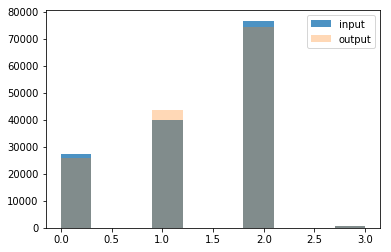

In [77]:
plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(input_gp, alpha=0.8, label='input')
plt.hist(output_gp, alpha=0.3, label='output')
plt.yscale('log')
plt.legend()
plt.show()

#### Original data

In [78]:
X_input_ori = X_input_num  # Do not contain nan
Y_input_ori = Y_input_num
X_output_ori = X_output_num
if test_length:
    Y_output_ori = Y_output_num

In [79]:
if test_length:
    arr_info((X_input, Y_input, X_output, Y_output, 
              X_input_ori, Y_input_ori, X_output_ori, Y_output_ori))
else:
    arr_info((X_input, Y_input, X_output, 
              X_input_ori, Y_input_ori, X_output_ori))

shape, min, max, median, stdev
(145063, 64) -59.5714 8.06325 0.0 1.02215
(145063, 64) -142.372 108.989 0.0 2.18937
(145063, 64) -12.1129 8.06325 0.0 1.01822
(145063, 64) 0.0 6.72643e+07 130.0 156903.0
(145063, 64) 0.0 3.3447e+07 140.0 83270.1
(145063, 64) 0.0 1.90625e+07 115.0 58162.8


plt.hist(X_input.reshape(-1),bins=40, range=[-10,10],alpha=0.6)
plt.show()
plt.hist(Y_input.reshape(-1),bins=40, range=[-10,10],alpha=0.6)
plt.show()
plt.hist(Y_output.reshape(-1),bins=40, range=[-10,10],alpha=0.6)
plt.show()

arr_info((Z_input,))

#### Min and max cases examination

np.argmin(Y_output, axis=0)

Y_output[8604]

Y_output_ori[8604]

fib_output_median[8604]

log(Y_output_ori[8604])

log(fib_output_median[8604])

np.std(log(Y_output_ori[8604]))

np.std(log(X_output_ori[8604]))

output_scale[8604]

#### Check if the inverse transformation is correct

#Undo transformation
X_input_tt = unlog(untransform(X_input, X_input_center, X_input_scale))

X_input_tt_diff = X_input_tt - X_input_ori
X_input_tt_diff.min(), X_input_tt_diff.max()

del X_input_tt_diff; del X_input_tt

## Split X,Y data into groups

X_input[input_gp == 1].shape

In [80]:
X_input_list = [X_input[input_gp == gp] for gp in gp_list]
Y_input_list = [Y_input[input_gp == gp] for gp in gp_list]
X_output_list = [X_output[output_gp == gp] for gp in gp_list]
if test_length:
    Y_output_list = [Y_output[output_gp == gp] for gp in gp_list]

Z_input_list = [Z_input[input_gp == gp] for gp in gp_list]
Z_output_list = [Z_output[output_gp == gp] for gp in gp_list]

## Additional input for the neural network

#Split center into group
Y_input_center_list = [Y_input_center[input_gp == gp] for gp in gp_list]
Y_output_center_list = [Y_output_center[output_gp == gp] for gp in gp_list]

#Split scale into group
input_scale_list = [input_scale[input_gp == gp] for gp in gp_list]
output_scale_list = [output_scale[output_gp == gp] for gp in gp_list]

input_scale_list[0].shape

In [81]:
A_input = np.concatenate((Y_input_center, input_scale), axis=1)
A_output = np.concatenate((Y_output_center, output_scale), axis=1); A_input.shape, A_output.shape

((145063, 2), (145063, 2))

In [82]:
A_input_list = [A_input[input_gp == gp] for gp in gp_list]
A_output_list = [A_output[output_gp == gp] for gp in gp_list]

In [83]:
a_length = len(A_input[0]); a_length

2

## Dates that We don't evaluate their scores !!!!
We modify Y_output_raw so that some of the dates won't be evaluated.

In [84]:
y_eval_length = 63
y_not_eval = y_length - y_eval_length  # number of days we don't evaluate their scores
y_not_eval

1

In [85]:
if test_length and y_not_eval > 0:
    Y_output_raw[:,:y_not_eval] = np.nan

In [86]:
if test_length and y_not_eval > 0:
    print(np.sum(~np.isnan(Y_output_raw[0])), y_eval_length, y_length)

In [87]:
if test_length and y_not_eval > 0:
    print(Y_output_raw[0:2,y_not_eval-1:y_not_eval+1])

#### Shuffle Index

In [88]:
def make_shuffle_index(n, seed=None):
    shuffle_index = np.arange(n)
    np.random.seed(seed)  # you can fix the initial seed for comparison purpose
    np.random.shuffle(shuffle_index)
    return shuffle_index

## Neural Network?

In [89]:
import keras

Using TensorFlow backend.


### SMAPE
Symmetric mean absolute percentage error

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [90]:
import keras.backend as K

def k_smape(y_true, y_pred):
    '''Symmetric mean absolute percentage error for keras metric'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred),
                                            K.epsilon(), None))
    return 200. * K.mean(diff, axis=-1)

In [91]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), np.float32(1e-07), None))
    return np.float32(200.) * np.nanmean(diff, axis=axis)

smape(np.array([0,1]),np.array([np.nan, 0])), smape(np.array([0]),np.array([0]))

In [92]:
# Benchmark SMAPE on the transformed data
smape(Y_input[:,-x_length:],X_input), smape(Y_input[:,-x_length:], X_output), smape(Y_input,Y_input)

(145.60228, 148.14798, 0.0)

In [93]:
# Benchmark SMAPE on the original data
smape(Y_input_raw[:,-x_length:],X_input_ori), smape(Y_input_ori[:,-x_length:],X_input_ori)

(61.357765, 60.374653)

In [94]:
if test_length: print(smape(Y_output_raw[:,-x_length:], X_output_ori), smape(Y_output[:,-x_length:], X_output))

In [95]:
print(smape(Y_input_raw, Y_input_fib))
if test_length: print(smape(Y_output_raw, Y_output_fib))

47.3282


Doing better than the first two scores are better than simply copy and past the previous result.

### Neural Network Model
With the flavor of convolutional neural network

In [99]:
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Reshape
from keras.layers import MaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import concatenate
from keras.optimizers import Adam
from keras.models import load_model

In [97]:
n_ens = 5
ens_list = list(range(n_ens))

In [100]:
#load model
load_previous_models = False
if load_previous_models:
    print('Load Previous Models')
    models_ens = [[load_model('../models/' + model_name + '-' + str(run) + '-' + str(gp) +'.h5',
                                custom_objects={'k_smape': k_smape})
                   for gp in gp_list]
                  for run in ens_list]
else: print('Not loading.')

Load Previous Models


In [104]:
#runbelow
if not load_previous_models:
    models_ens = []
    for run in ens_list:
        print('Run', run, end=': ')
        models = []
        for gp in gp_list:
            print('Group-', gp, sep='', end=' ')
            layer_0 = Input(shape=(x_length,), name='x_input')
            layer_t = Reshape((-1, 1))(layer_0)
            layer_t = Conv1D(140, kernel_size=3, activation='relu')(layer_t)
            layer_t = AveragePooling1D(pool_size=2)(layer_t)
            layer_cnn_x = Flatten()(layer_t)

            layer_a = Input(shape=(a_length,), name='a_input')

            #layer_z = Input(shape=(y_length,), name='z_input')
            #layer_t = Reshape((-1, 1))(layer_0)
            #layer_t = Conv1D(20, kernel_size=3, activation='relu')(layer_t)
            #layer_t = AveragePooling1D(pool_size=2)(layer_t)
            #layer_cnn_z = Flatten()(layer_t)

            layer_t = concatenate([layer_cnn_x, layer_a])#, layer_cnn_z])

            layer_t = Dense(130, activation='relu')(layer_t)
            layer_t = Dropout(0.25)(layer_t)
            layer_t = Dense(120, activation='relu')(layer_t)
            layer_t = Dropout(0.5)(layer_t)
            layer_f = Dense(y_length)(layer_t)

            model = Model(inputs=[layer_0, layer_a], outputs=layer_f)
            #model = Model(inputs=[layer_0, layer_a, layer_z], outputs=layer_f)
            model.compile(optimizer='adam',
                          loss='mean_absolute_error', metrics=[k_smape])
            #model.summary()
            models.append(model)
        models_ens.append(models)
        print('')

Run 0: Group-0 Group-1 Group-2 Group-3 
Run 1: Group-0 Group-1 Group-2 Group-3 
Run 2: Group-0 Group-1 Group-2 Group-3 
Run 3: Group-0 Group-1 Group-2 Group-3 
Run 4: Group-0 Group-1 Group-2 Group-3 


In [101]:
models_ens[-1][-1].summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
x_input (InputLayer)             (None, 64)            0                                            
____________________________________________________________________________________________________
reshape_20 (Reshape)             (None, 64, 1)         0           x_input[0][0]                    
____________________________________________________________________________________________________
conv1d_20 (Conv1D)               (None, 62, 140)       560         reshape_20[0][0]                 
____________________________________________________________________________________________________
average_pooling1d_20 (AveragePoo (None, 31, 140)       0           conv1d_20[0][0]                  
___________________________________________________________________________________________

In [102]:
np.array(models_ens).shape

(5, 4)

In [103]:
len(gp_list)

4

In [104]:
epochs_list = [0,40,40,60]  # change to smaller epochs later (1,1,20,40,60,80)

In [109]:
%%time
if load_previous_models:
    print('Use Previous Model. Not training.')
else:
    hists_ens = []
    shuffle_indexs_ens = []
    for run, models in zip(ens_list, models_ens):
        print('=== Run:', run+1, '/', len(ens_list), '===')
        hists = []
        shuffle_indexs = []
        for (gp, model, X_in, Y_in, epochs, A_in) in zip(gp_list, models,
                                           X_input_list, Y_input_list, 
                                           epochs_list, A_input_list):
            print('--- Group:', gp+1, '/', len(gp_list), '---')

            shuffle_index = make_shuffle_index(len(X_in))  # Shuffle
            X_in_sh = X_in[shuffle_index]
            Y_in_sh = Y_in[shuffle_index]
            A_in_sh = A_in[shuffle_index]

            hist = model.fit([X_in_sh, A_in_sh], Y_in_sh, batch_size=128, 
                             epochs=epochs, 
                             validation_split=0.2, verbose=2)
            #validation_data=(X_val, Y_val))
            hists.append(hist)
            shuffle_indexs.append(shuffle_index)
        hists_ens.append(hists)
        shuffle_indexs_ens.append(shuffle_indexs)

=== Run: 1 / 5 ===
--- Group: 1 / 4 ---
Train on 21930 samples, validate on 5483 samples
--- Group: 2 / 4 ---
Train on 32032 samples, validate on 8009 samples
Epoch 1/40
8s - loss: 1.0614 - k_smape: 156.2782 - val_loss: 1.0372 - val_k_smape: 151.3083
Epoch 2/40
7s - loss: 1.0408 - k_smape: 148.7826 - val_loss: 1.0318 - val_k_smape: 151.0849
Epoch 3/40
7s - loss: 1.0332 - k_smape: 146.3260 - val_loss: 1.0276 - val_k_smape: 145.6618
Epoch 4/40
7s - loss: 1.0287 - k_smape: 145.1344 - val_loss: 1.0258 - val_k_smape: 146.9720
Epoch 5/40
7s - loss: 1.0240 - k_smape: 143.9593 - val_loss: 1.0221 - val_k_smape: 144.8657
Epoch 6/40
7s - loss: 1.0221 - k_smape: 143.4483 - val_loss: 1.0199 - val_k_smape: 144.3891
Epoch 7/40
7s - loss: 1.0183 - k_smape: 142.8454 - val_loss: 1.0182 - val_k_smape: 143.2944
Epoch 8/40
7s - loss: 1.0163 - k_smape: 142.4887 - val_loss: 1.0168 - val_k_smape: 141.9082
Epoch 9/40
7s - loss: 1.0134 - k_smape: 141.9564 - val_loss: 1.0158 - val_k_smape: 142.4166
Epoch 10/40
7

0s - loss: 1.1481 - k_smape: 138.1285 - val_loss: 1.1818 - val_k_smape: 135.8950
Epoch 8/60
0s - loss: 1.1196 - k_smape: 134.0603 - val_loss: 1.1653 - val_k_smape: 132.7992
Epoch 9/60
0s - loss: 1.1052 - k_smape: 131.8685 - val_loss: 1.1464 - val_k_smape: 128.7330
Epoch 10/60
0s - loss: 1.0890 - k_smape: 127.3730 - val_loss: 1.1309 - val_k_smape: 125.6123
Epoch 11/60
0s - loss: 1.0777 - k_smape: 125.7813 - val_loss: 1.1330 - val_k_smape: 127.4893
Epoch 12/60
0s - loss: 1.0545 - k_smape: 124.9751 - val_loss: 1.1199 - val_k_smape: 122.1838
Epoch 13/60
0s - loss: 1.0454 - k_smape: 121.2790 - val_loss: 1.1210 - val_k_smape: 124.8543
Epoch 14/60
0s - loss: 1.0317 - k_smape: 120.4062 - val_loss: 1.1011 - val_k_smape: 119.4742
Epoch 15/60
0s - loss: 1.0070 - k_smape: 116.1903 - val_loss: 1.0946 - val_k_smape: 116.3124
Epoch 16/60
0s - loss: 0.9976 - k_smape: 114.9297 - val_loss: 1.0976 - val_k_smape: 118.0232
Epoch 17/60
0s - loss: 0.9853 - k_smape: 113.8944 - val_loss: 1.0945 - val_k_smape: 

7s - loss: 0.9471 - k_smape: 134.7586 - val_loss: 1.0266 - val_k_smape: 140.5857
Epoch 35/40
7s - loss: 0.9464 - k_smape: 134.6325 - val_loss: 1.0234 - val_k_smape: 140.6470
Epoch 36/40
7s - loss: 0.9445 - k_smape: 134.5181 - val_loss: 1.0212 - val_k_smape: 141.1268
Epoch 37/40
7s - loss: 0.9432 - k_smape: 134.7043 - val_loss: 1.0213 - val_k_smape: 141.5603
Epoch 38/40
7s - loss: 0.9403 - k_smape: 134.2763 - val_loss: 1.0215 - val_k_smape: 140.2307
Epoch 39/40
7s - loss: 0.9417 - k_smape: 134.3539 - val_loss: 1.0234 - val_k_smape: 141.8633
Epoch 40/40
7s - loss: 0.9382 - k_smape: 133.9569 - val_loss: 1.0242 - val_k_smape: 141.0972
--- Group: 3 / 4 ---
Train on 61452 samples, validate on 15363 samples
Epoch 1/40
14s - loss: 1.0888 - k_smape: 128.5937 - val_loss: 1.0346 - val_k_smape: 118.6560
Epoch 2/40
13s - loss: 1.0488 - k_smape: 121.2252 - val_loss: 1.0231 - val_k_smape: 114.9077
Epoch 3/40
13s - loss: 1.0377 - k_smape: 119.3089 - val_loss: 1.0152 - val_k_smape: 117.6677
Epoch 4/40


0s - loss: 0.8087 - k_smape: 96.1066 - val_loss: 1.0034 - val_k_smape: 103.1578
Epoch 42/60
0s - loss: 0.8104 - k_smape: 96.9105 - val_loss: 0.9987 - val_k_smape: 102.8021
Epoch 43/60
0s - loss: 0.8042 - k_smape: 96.1411 - val_loss: 1.0059 - val_k_smape: 104.1845
Epoch 44/60
0s - loss: 0.8003 - k_smape: 95.2699 - val_loss: 0.9935 - val_k_smape: 102.3183
Epoch 45/60
0s - loss: 0.8076 - k_smape: 96.2931 - val_loss: 1.0087 - val_k_smape: 104.8732
Epoch 46/60
0s - loss: 0.8141 - k_smape: 96.3621 - val_loss: 0.9895 - val_k_smape: 101.9961
Epoch 47/60
0s - loss: 0.7948 - k_smape: 95.3983 - val_loss: 1.0018 - val_k_smape: 106.0652
Epoch 48/60
0s - loss: 0.7907 - k_smape: 95.5470 - val_loss: 0.9868 - val_k_smape: 102.5927
Epoch 49/60
0s - loss: 0.7873 - k_smape: 94.6279 - val_loss: 0.9869 - val_k_smape: 103.2815
Epoch 50/60
0s - loss: 0.7900 - k_smape: 94.5805 - val_loss: 0.9892 - val_k_smape: 103.5005
Epoch 51/60
0s - loss: 0.7886 - k_smape: 94.1483 - val_loss: 0.9912 - val_k_smape: 103.4117


13s - loss: 0.9579 - k_smape: 110.8742 - val_loss: 0.9740 - val_k_smape: 112.7699
Epoch 28/40
13s - loss: 0.9576 - k_smape: 110.8990 - val_loss: 0.9796 - val_k_smape: 116.0601
Epoch 29/40
13s - loss: 0.9563 - k_smape: 110.8191 - val_loss: 0.9694 - val_k_smape: 111.7036
Epoch 30/40
13s - loss: 0.9513 - k_smape: 110.1825 - val_loss: 0.9705 - val_k_smape: 112.7166
Epoch 31/40
13s - loss: 0.9521 - k_smape: 110.3826 - val_loss: 0.9675 - val_k_smape: 111.0809
Epoch 32/40
13s - loss: 0.9501 - k_smape: 110.3081 - val_loss: 0.9673 - val_k_smape: 111.1046
Epoch 33/40
13s - loss: 0.9462 - k_smape: 109.8946 - val_loss: 0.9726 - val_k_smape: 111.9447
Epoch 34/40
13s - loss: 0.9464 - k_smape: 109.9501 - val_loss: 0.9680 - val_k_smape: 112.6035
Epoch 35/40
13s - loss: 0.9449 - k_smape: 109.8200 - val_loss: 0.9713 - val_k_smape: 111.6167
Epoch 36/40
13s - loss: 0.9435 - k_smape: 109.7094 - val_loss: 0.9678 - val_k_smape: 110.7334
Epoch 37/40
13s - loss: 0.9414 - k_smape: 109.4828 - val_loss: 0.9717 - 

7s - loss: 0.9931 - k_smape: 138.9629 - val_loss: 1.0162 - val_k_smape: 140.6650
Epoch 15/40
7s - loss: 0.9911 - k_smape: 139.0423 - val_loss: 1.0124 - val_k_smape: 142.5373
Epoch 16/40
7s - loss: 0.9865 - k_smape: 138.3887 - val_loss: 1.0120 - val_k_smape: 141.6557
Epoch 17/40
7s - loss: 0.9841 - k_smape: 138.2712 - val_loss: 1.0155 - val_k_smape: 142.8843
Epoch 18/40
7s - loss: 0.9819 - k_smape: 137.9944 - val_loss: 1.0145 - val_k_smape: 144.1908
Epoch 19/40
7s - loss: 0.9794 - k_smape: 137.9492 - val_loss: 1.0139 - val_k_smape: 143.7424
Epoch 20/40
7s - loss: 0.9774 - k_smape: 137.8701 - val_loss: 1.0121 - val_k_smape: 141.6116
Epoch 21/40
7s - loss: 0.9741 - k_smape: 137.4355 - val_loss: 1.0117 - val_k_smape: 142.5576
Epoch 22/40
7s - loss: 0.9702 - k_smape: 137.0907 - val_loss: 1.0139 - val_k_smape: 142.0071
Epoch 23/40
7s - loss: 0.9678 - k_smape: 137.0023 - val_loss: 1.0128 - val_k_smape: 141.8667
Epoch 24/40
7s - loss: 0.9655 - k_smape: 136.7379 - val_loss: 1.0122 - val_k_smape

0s - loss: 0.9833 - k_smape: 109.3995 - val_loss: 0.8775 - val_k_smape: 106.5299
Epoch 22/60
0s - loss: 0.9673 - k_smape: 108.6109 - val_loss: 0.8777 - val_k_smape: 108.5388
Epoch 23/60
0s - loss: 0.9643 - k_smape: 107.8829 - val_loss: 0.8747 - val_k_smape: 108.6873
Epoch 24/60
0s - loss: 0.9561 - k_smape: 107.6029 - val_loss: 0.8712 - val_k_smape: 107.0481
Epoch 25/60
0s - loss: 0.9366 - k_smape: 104.4714 - val_loss: 0.8700 - val_k_smape: 107.0157
Epoch 26/60
0s - loss: 0.9220 - k_smape: 104.4327 - val_loss: 0.8730 - val_k_smape: 107.9720
Epoch 27/60
0s - loss: 0.9153 - k_smape: 102.5645 - val_loss: 0.8659 - val_k_smape: 106.3718
Epoch 28/60
0s - loss: 0.9168 - k_smape: 103.0810 - val_loss: 0.8678 - val_k_smape: 105.5559
Epoch 29/60
0s - loss: 0.9166 - k_smape: 103.2947 - val_loss: 0.8748 - val_k_smape: 110.2461
Epoch 30/60
0s - loss: 0.9030 - k_smape: 103.2144 - val_loss: 0.8686 - val_k_smape: 105.5256
Epoch 31/60
0s - loss: 0.8993 - k_smape: 101.0949 - val_loss: 0.8741 - val_k_smape

13s - loss: 1.0069 - k_smape: 115.6233 - val_loss: 1.0099 - val_k_smape: 114.1030
Epoch 8/40
13s - loss: 1.0028 - k_smape: 115.2119 - val_loss: 1.0058 - val_k_smape: 113.3792
Epoch 9/40
13s - loss: 0.9970 - k_smape: 114.5834 - val_loss: 1.0044 - val_k_smape: 114.8228
Epoch 10/40
13s - loss: 0.9941 - k_smape: 114.2575 - val_loss: 0.9992 - val_k_smape: 113.3411
Epoch 11/40
13s - loss: 0.9891 - k_smape: 113.6882 - val_loss: 0.9982 - val_k_smape: 114.0318
Epoch 12/40
13s - loss: 0.9853 - k_smape: 113.3783 - val_loss: 0.9992 - val_k_smape: 113.1300
Epoch 13/40
13s - loss: 0.9836 - k_smape: 113.0862 - val_loss: 0.9935 - val_k_smape: 112.4829
Epoch 14/40
13s - loss: 0.9798 - k_smape: 112.9407 - val_loss: 0.9951 - val_k_smape: 113.8125
Epoch 15/40
13s - loss: 0.9761 - k_smape: 112.5116 - val_loss: 0.9883 - val_k_smape: 111.8333
Epoch 16/40
13s - loss: 0.9740 - k_smape: 112.2229 - val_loss: 0.9884 - val_k_smape: 111.7826
Epoch 17/40
14s - loss: 0.9696 - k_smape: 111.8940 - val_loss: 0.9909 - va

0s - loss: 0.7872 - k_smape: 93.7146 - val_loss: 0.9846 - val_k_smape: 105.6709
Epoch 56/60
0s - loss: 0.7853 - k_smape: 94.6287 - val_loss: 1.0109 - val_k_smape: 110.7489
Epoch 57/60
0s - loss: 0.7888 - k_smape: 95.8185 - val_loss: 0.9819 - val_k_smape: 106.2239
Epoch 58/60
0s - loss: 0.7682 - k_smape: 93.0949 - val_loss: 0.9857 - val_k_smape: 106.1742
Epoch 59/60
0s - loss: 0.7755 - k_smape: 92.6817 - val_loss: 0.9963 - val_k_smape: 106.5816
Epoch 60/60
0s - loss: 0.7733 - k_smape: 93.3116 - val_loss: 0.9866 - val_k_smape: 106.2605
Wall time: 1h 24min 57s


%%time
hists_ens = []
for run, models in zip(ens_list, models_ens):
    print('=== Run:', run+1, '/', len(ens_list), '===')
    hists = []
    for (gp, model, X_in, Y_in, epochs, A_in, Z_in) in zip(gp_list, models,
                                       X_input_list, Y_input_list, 
                                       epochs_list, A_input_list, Z_input_list):
        print('--- Group:', gp+1, '/', len(gp_list), '---')
        hist = model.fit([X_in, A_in, Z_in], Y_in, batch_size=128, 
                         epochs=epochs, 
                         validation_split=0.1, verbose=2)
        #validation_data=(X_val, Y_val))
        hists.append(hist)
    hists_ens.append(hists)

### Save the Model

In [110]:
if not load_previous_models:
    for run in ens_list:
        for gp in gp_list:
            models_ens[run][gp].save('../models/' + model_name + '-' + str(run) + '-' + str(gp) +'.h5')

### Training History

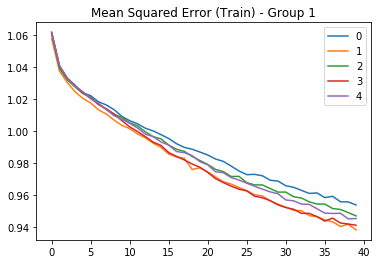

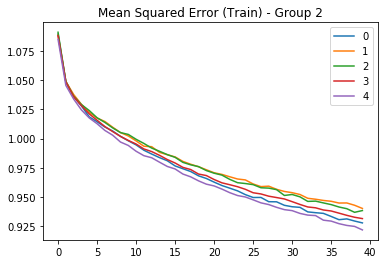

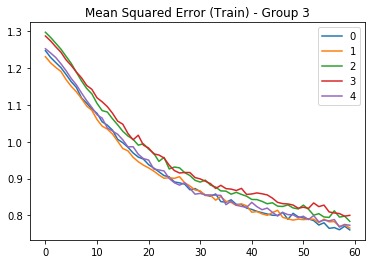

In [111]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['loss'], label=str(run))
        plt.title('Mean Squared Error (Train) - Group ' + str(gp))
        plt.legend(); plt.show()        

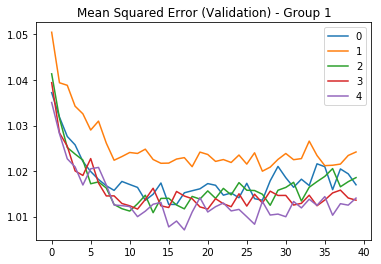

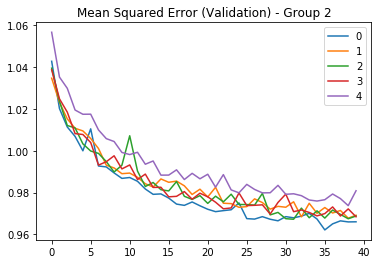

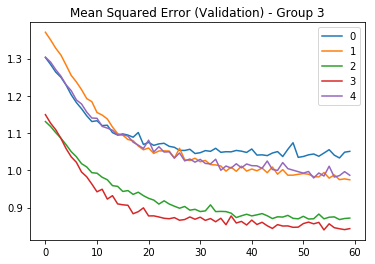

In [112]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_loss'], label=str(run))
        plt.title('Mean Squared Error (Validation) - Group ' + str(gp))
        plt.legend(); plt.show()        

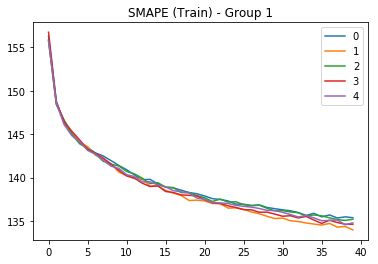

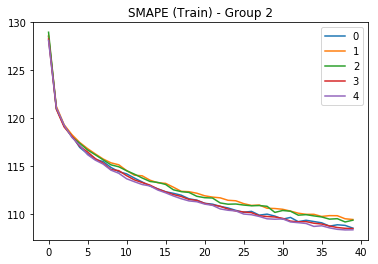

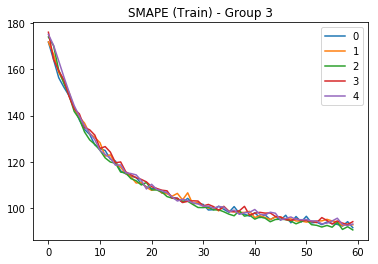

In [113]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['k_smape'], label=str(run))
        plt.title('SMAPE (Train) - Group ' + str(gp))
        plt.legend(); plt.show()        

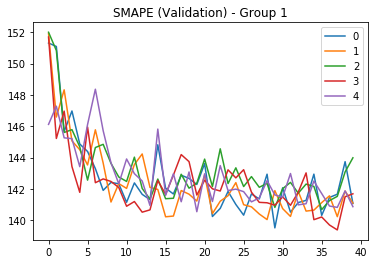

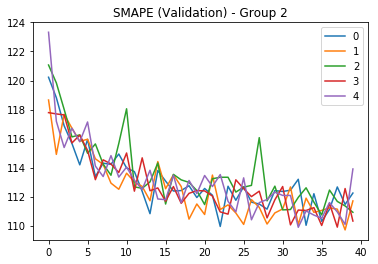

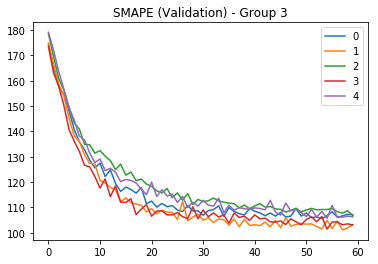

In [114]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_k_smape'], label=str(run))
        plt.title('SMAPE (Validation) - Group ' + str(gp))
        plt.legend(); plt.show()        

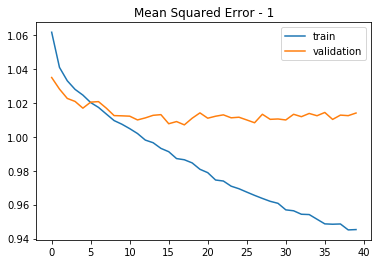

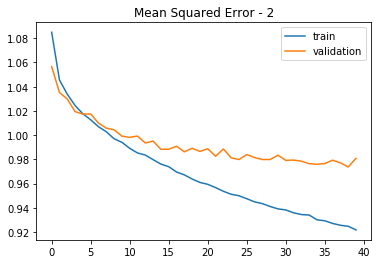

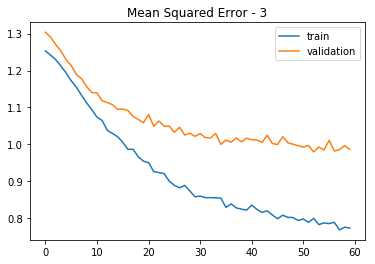

In [115]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

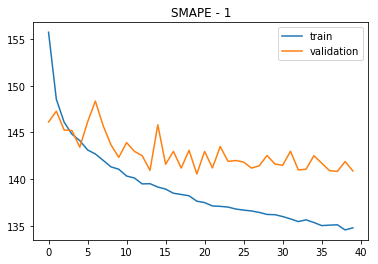

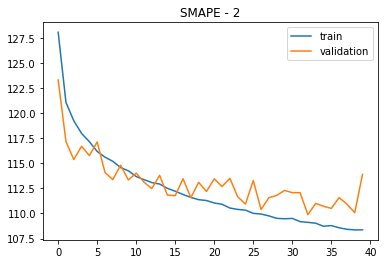

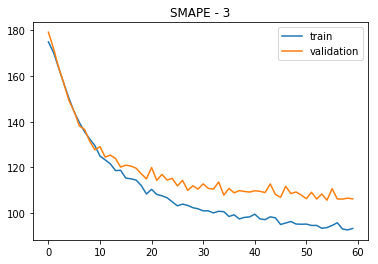

In [116]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

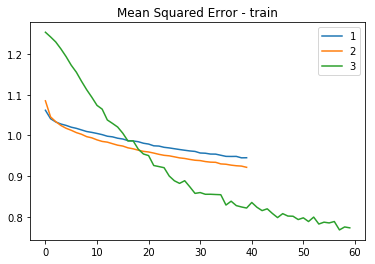

In [117]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

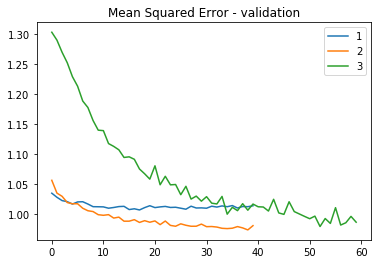

In [118]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

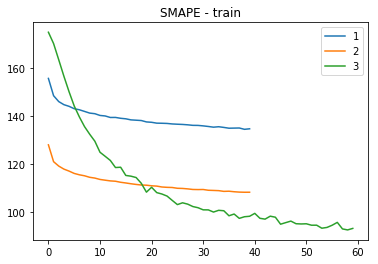

In [119]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

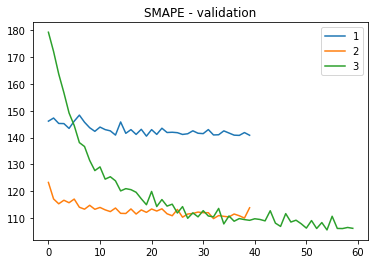

In [120]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

### More Training

epochs_list2 = [0,10,0,0,10]

hists2 = []
for (gp, model, X_in, Y_in, epochs) in zip(gp_list, models,
                                   X_input_list, Y_input_list, 
                                   epochs_list2):
    hist = model.fit(X_in, Y_in, batch_size=128, 
                     epochs=epochs, 
                     validation_split=0.05)
    #validation_data=(X_val, Y_val))
    hists2.append(hist)

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs:
        plt.plot(hist.history['loss'], label=gp)
plt.title('Mean Squared Error - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_loss'], label=gp)
plt.title('Mean Squared Error - validation')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['k_smape'], label=gp)
plt.title('SMAPE - train')
plt.legend(); plt.show()

for (hist, gp, epochs) in zip(hists2, gp_list, epochs_list2):
    if epochs: plt.plot(hist.history['val_k_smape'], label=gp)
plt.title('SMAPE - validation')
plt.legend(); plt.show()

## Predict for Input Set (Training Set)

In [119]:
%%time
Y_input_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_input_pred_list = []
    for (gp, model, X, A) in zip(gp_list, models, X_input_list, A_input_list):
        print(gp, end=' ')
        Y_input_pred_list.append(model.predict([X, A]))
    Y_input_pred_list_ens.append(Y_input_pred_list)
    print('')

Run 0: 0 1 2 3 
Run 1: 0 1 2 3 
Run 2: 0 1 2 3 
Run 3: 0 1 2 3 
Run 4: 0 1 2 3 
Wall time: 1min 3s


%%time
Y_input_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_input_pred_list = []
    for (gp, model, X, A, Z) in zip(gp_list, models, X_input_list, A_input_list, Z_input_list):
        print(gp, end=' ')
        Y_input_pred_list.append(model.predict([X, A, Z]))
    Y_input_pred_list_ens.append(Y_input_pred_list)
    print('')

Find the original index

In [120]:
input_index_range = np.arange(len(input_gp)); #input_index_range

In [121]:
# list for original index
input_index_list = [input_index_range[input_gp == gp] 
                     for gp in gp_list]

In [122]:
for o in input_index_list:
    print(o.shape, end=' ')

(27413,) (40041,) (76815,) (794,) 

In [123]:
input_index_list_comb = np.concatenate(input_index_list); #input_index_list_comb

In [124]:
Y_input_pred_ens = []
for Y_input_pred_list in Y_input_pred_list_ens:
    Y_input_pred_comb = np.concatenate(Y_input_pred_list)
    Y_input_pred = [0]*len(input_index_list_comb)

    for index, y in zip(input_index_list_comb, Y_input_pred_comb):
        Y_input_pred[index] = y

    Y_input_pred = np.array(Y_input_pred)  # make it an numpy array (which will also make a copy)
    Y_input_pred_ens.append(Y_input_pred)

del Y_input_pred_comb

In [125]:
# Inverse transform Y_input_pred to original Y
Y_input_pred_ori_ens = []
for Y_input_pred in Y_input_pred_ens:
    Y_input_pred_ori = unlog(untransform(Y_input_pred, 
                                          Y_input_center, Y_input_scale))
    Y_input_pred_ori_ens.append(Y_input_pred_ori)

In [126]:
Y_input_pred_ori_ens = np.array(Y_input_pred_ori_ens)

## Predict for Output Set

In [105]:
%%time
Y_output_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_output_pred_list = []
    for (gp, model, X, A) in zip(gp_list, models, X_output_list, A_output_list):
        print(gp, end=' ')
        Y_output_pred_list.append(model.predict([X, A]))
    Y_output_pred_list_ens.append(Y_output_pred_list)
    print('')

Run 0: 0 1 2 3 
Run 1: 0 1 2 3 
Run 2: 0 1 2 3 
Run 3: 0 1 2 3 
Run 4: 0 1 2 3 
Wall time: 1min 9s


%%time
Y_output_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_output_pred_list = []
    for (gp, model, X, A, Z) in zip(gp_list, models, X_output_list, A_output_list, Z_output_list):
        print(gp, end=' ')
        Y_output_pred_list.append(model.predict([X, A, Z]))
    Y_output_pred_list_ens.append(Y_output_pred_list)
    print('')

Find the original index

In [106]:
output_index_range = np.arange(len(output_gp)); #output_index_range

In [107]:
# list for original index
output_index_list = [output_index_range[output_gp == gp] 
                     for gp in gp_list]

In [108]:
for o in output_index_list:
    print(o.shape, end=' ')

(25996,) (43804,) (74588,) (675,) 

In [109]:
output_index_list_comb = np.concatenate(output_index_list); #output_index_list_comb

In [110]:
Y_output_pred_ens = []
for Y_output_pred_list in Y_output_pred_list_ens:
    Y_output_pred_comb = np.concatenate(Y_output_pred_list)
    Y_output_pred = [0]*len(output_index_list_comb)

    for index, y in zip(output_index_list_comb, Y_output_pred_comb):
        Y_output_pred[index] = y

    Y_output_pred = np.array(Y_output_pred)  # make it an numpy array (which will also make a copy)
    Y_output_pred_ens.append(Y_output_pred)

del Y_output_pred_comb

In [111]:
# Inverse transform Y_output_pred to original Y
Y_output_pred_ori_ens = []
for Y_output_pred in Y_output_pred_ens:
    Y_output_pred_ori = unlog(untransform(Y_output_pred, 
                                          Y_output_center, Y_output_scale))
    Y_output_pred_ori_ens.append(Y_output_pred_ori)

In [112]:
Y_output_pred_ori_ens = np.array(Y_output_pred_ori_ens)

#### Check predict output

Y_output_pred

Y_output_pred_ori

examine(Y_output_pred)

examine(Y_output_pred_ori)

view(X_output_ori[126420])

## SMAPE Scores

### Model Score

In [127]:
# SMAPE scores for the model
if test_length:
    model_smape_ens = []
    model_smape_0_ens = []
    for Y_output_pred_ori in Y_output_pred_ori_ens:
        model_smape = smape(Y_output_raw, Y_output_pred_ori) # SMAPE score excluding nan (Correct one)
        model_smape_0 = smape(Y_output_ori, Y_output_pred_ori) # SMAPE assuming nan == 0
        
        model_smape_ens.append(model_smape)
        model_smape_0_ens.append(model_smape_0)
    model_smape_ens_mean = np.mean(model_smape_ens)
    model_smape_0_ens_mean = np.mean(model_smape_0_ens)
    
    model_smape_stdev = np.std(model_smape_ens)  # standard deviation of the smape score
    model_smape_0_stdev = np.std(model_smape_0_ens)  # standard deviation of the smape score
    
    model_smape_ens_mean_std = model_smape_stdev / np.sqrt(len(model_smape_ens))

In [128]:
if test_length:
    for model_smape, model_smape_0 in zip(model_smape_ens, model_smape_0_ens):
        print('%6.3f' % model_smape, '       ', '%6.3f' % model_smape_0)
    print('-----------------------------')
    print('%6.3f' % model_smape_ens_mean, '+-%5.3f' % model_smape_stdev, 
          '%6.3f' % model_smape_0_ens_mean, '+-%5.3f' % model_smape_0_stdev)
    print('+-%5.3f' % model_smape_ens_mean_std)

In [129]:
# SMAPE score for Fibonacci median
if test_length:
    fib_smape = smape(Y_output_raw, Y_output_fib)
    print(fib_smape)

In [130]:
esmape = smape

In [131]:
# Estimated SMAPE scores for the model using training set
model_esmape_ens = []
model_esmape_0_ens = []
for Y_input_pred_ori in Y_input_pred_ori_ens:
    model_esmape = esmape(Y_input_raw, Y_input_pred_ori) # SMAPE score excluding nan (Correct one)
    model_esmape_0 = esmape(Y_input_ori, Y_input_pred_ori) # SMAPE assuming nan == 0
    
    model_esmape_ens.append(model_esmape)
    model_esmape_0_ens.append(model_esmape_0)
model_esmape_ens_mean = np.mean(model_esmape_ens)
model_esmape_0_ens_mean = np.mean(model_esmape_0_ens)

model_esmape_stdev = np.std(model_esmape_ens)  # standard deviation of the esmape score
model_esmape_0_stdev = np.std(model_esmape_0_ens)  # standard deviation of the esmape score

model_esmape_ens_mean_std = model_esmape_stdev / np.sqrt(len(model_esmape_ens))

In [132]:
for model_esmape, model_esmape_0 in zip(model_esmape_ens, model_esmape_0_ens):
    print('%6.3f' % model_esmape, '       ', '%6.3f' % model_esmape_0)
print('-----------------------------')
print('%6.3f' % model_esmape_ens_mean, '+-%5.3f' % model_esmape_stdev, 
      '%6.3f' % model_esmape_0_ens_mean, '+-%5.3f' % model_esmape_0_stdev)
print('+-%5.3f' % model_esmape_ens_mean_std)

39.265         42.372
39.300         42.800
39.360         42.582
39.146         42.452
39.389         42.923
-----------------------------
39.292 +-0.085 42.626 +-0.208
+-0.038


In [133]:
# SMAPE Est score for Fibonacci median
fib_esmape = esmape(Y_input_raw, Y_input_fib)
print(fib_esmape)

47.3282


### Group Scores

In [134]:
# Prediction Y_output in group
Y_output_pred_ori_list_ens = [[Y_output_pred_ori[output_gp == gp] for gp in gp_list]
                              for Y_output_pred_ori in Y_output_pred_ori_ens]
#Y_output_pred_ori_list = [Y_output_pred_ori[output_gp == gp] for gp in gp_list]
Y_output_pred_ori_list = Y_output_pred_ori_list_ens[-1]  # in case you want to see one of them

In [135]:
# Prediction Y_input in group
Y_input_pred_ori_list_ens = [[Y_input_pred_ori[input_gp == gp] for gp in gp_list]
                              for Y_input_pred_ori in Y_input_pred_ori_ens]
#Y_input_pred_ori_list = [Y_input_pred_ori[input_gp == gp] for gp in gp_list]
Y_input_pred_ori_list = Y_input_pred_ori_list_ens[-1]  # in case you want to see one of them

In [136]:
# Fibonacci median in group
Y_output_fib_list = [Y_output_fib[output_gp == gp] for gp in gp_list]

In [137]:
# Fibonacci median in group
Y_input_fib_list = [Y_input_fib[input_gp == gp] for gp in gp_list]

In [138]:
# True Y_output in group
if test_length:
    # untransformed Y_output with nan replaced by 0
    Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]
    
    # untransformed Y_output_ori with nan (for SMAPE estimation)
    Y_output_raw_list = [Y_output_raw[output_gp == gp] for gp in gp_list]

In [139]:
# True Y_input in group
# untransformed Y_input with nan replaced by 0
Y_input_ori_list = [Y_input_ori[input_gp == gp] for gp in gp_list]

# untransformed Y_input_ori with nan (for SMAPE estimation)
Y_input_raw_list = [Y_input_raw[input_gp == gp] for gp in gp_list]

In [140]:
X_output_ori_list = [X_output_ori[input_gp == gp] for gp in gp_list]

In [141]:
tot_n = len(output_gp); tot_n  # total number of pages in output set

145063

In [142]:
def count_not_nan(data):
    return np.count_nonzero(~np.isnan(data))

In [143]:
# Group scores for the model
if test_length:
    gp_output_n = [len(Y) for Y in Y_output_raw_list]
    # SMAPE with nan values ignored (used by Kaggle)
    gp_smape_ens = [[smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_list)]
                    for Y_output_pred_ori_list in Y_output_pred_ori_list_ens]
    gp_smape = gp_smape_ens[-1]    
    gp_smape_mean = np.mean(gp_smape_ens, axis=0)
    print(gp_smape_mean)

In [144]:
# Group estimated scores for the model
gp_input_n = [len(Y) for Y in Y_input_raw_list]
# SMAPE with nan values ignored (used by Kaggle)
gp_esmape_ens = [[esmape(Y, Y_p) for Y, Y_p in zip(Y_input_raw_list, Y_input_pred_ori_list)]
                for Y_input_pred_ori_list in Y_input_pred_ori_list_ens]
gp_esmape = gp_esmape_ens[-1]    
gp_esmape_mean = np.mean(gp_esmape_ens, axis=0)
print(gp_esmape_mean)

[ 70.40036774  40.46203232  29.60982704  23.70744896]


if test_length:
    #gp_smape = [smape(Y, Y_p) for Y, Y_p 
    #            in zip(Y_output_raw_list, Y_output_pred_ori_list)]
    
    #n_not_nan = count_not_nan(Y_output_raw)
    #n_not_nan_gp = [count_not_nan(Y) for Y in Y_output_raw_list]
    #n_not_nan_ratio_gp = [n / (len(Y) * len(Y[0])) for Y,n 
    #                      in zip(Y_output_raw_list, n_not_nan_gp)]
    
    # SMAPE contribution
    #gp_smape_sum = [s * n for n, s in zip(gp_smape, n_not_nan_gp)]
    #gp_smape_cont = [s / n_not_nan for s in gp_smape_sum]

In [145]:
# Group score for Fibonacci median
if test_length:
    gp_smape_fib = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_fib_list)]

In [146]:
# Group Estimated score for Fibonacci median
gp_esmape_fib = [esmape(Y, Y_p) for Y, Y_p in zip(Y_input_raw_list, Y_input_fib_list)]

In [147]:
if test_length:  # gp_score compare
    print('#### ' + model_name)
    print('', end='|')
    print('N_pages ', 'Fibonacci', ' Average ', sep='|', end='|')
    for run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', sep='|', end='|')
    for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_output_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        for run in ens_list:
            print(' %7.3f ' % gp_smape_ens[run][gp], end='|')
        print('')
    print('|  Total ', ' %7.3f ' % fib_smape, ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')
    for run in ens_list:
            print(' %7.3f ' % model_smape_ens[run], end='|')

In [148]:
#Estimated gp_score compare
print('#### ' + model_name, 'Est')
print('', end='|')
print('N_pages ', 'Fibonacci', ' Average ', sep='|', end='|')
for run in ens_list: print(' Model', run, end=' |')
print('')
print('', end='|')
print('--------', '---------', '---------', sep='|', end='|')
for run in ens_list: print('---------', end='|')
print('')
for gp in gp_list:
    print('', end='|')
    print(' %6d ' % gp_input_n[gp], end='|')
    print(' %7.3f ' % gp_esmape_fib[gp], end='|')
    print(' %7.3f ' % gp_esmape_mean[gp], end='|')
    for run in ens_list:
        print(' %7.3f ' % gp_esmape_ens[run][gp], end='|')
    print('')
print('|  Total ', ' %7.3f ' % fib_esmape, ' %7.3f ' % model_esmape_ens_mean, sep='|', end='|')
for run in ens_list:
        print(' %7.3f ' % model_esmape_ens[run], end='|')

#### model_10_Modified_CNN_7_More_Neurons-Stage_2_Predict Est
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|  27413 |  67.261 |  70.400 |  70.083 |  70.499 |  70.311 |  70.435 |  70.675 |
|  40041 |  47.214 |  40.462 |  40.655 |  40.216 |  40.739 |  40.331 |  40.369 |
|  76815 |  41.531 |  29.610 |  29.552 |  29.717 |  29.620 |  29.404 |  29.756 |
|    794 |  41.575 |  23.707 |  23.971 |  24.223 |  23.294 |  23.472 |  23.576 |
|  Total |  47.328 |  39.292 |  39.265 |  39.300 |  39.360 |  39.146 |  39.389 |

#### model_10_Modified_CNN_4_The_Model
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.291 |  68.432 |  67.965 |  68.039 |  68.527 |  68.492 |
|  43691 |  40.612 |  39.986 |  39.863 |  39.935 |  40.101 |  39.696 |  40.336 |
|  75617 |  34.284 |  29.633 |  29.641 |  29.453 |  29.630 |  29.832 |  29.606 |
|    791 |  34.653 |  33.308 |  33.714 |  33.951 |  32.934 |  33.296 |  32.647 |
|  Total |  40.404 |  38.836 |  38.826 |  38.677 |  38.829 |  38.889 |  38.957 |
#### model_10_Modified_CNN_1_Z
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 158.876 | 166.920 | 167.117 | 154.478 | 165.189 | 140.678 |
|  23085 |  61.354 |  64.057 |  63.166 |  63.533 |  63.921 |  64.384 |  65.282 |
|  43691 |  40.612 |  40.025 |  40.088 |  39.890 |  40.224 |  40.132 |  39.794 |
|  75617 |  34.284 |  29.755 |  29.759 |  29.741 |  29.658 |  29.865 |  29.752 |
|    740 |  35.621 |  33.983 |  33.411 |  33.945 |  34.447 |  34.013 |  34.100 |
|     51 |  20.224 |  17.259 |  17.687 |  17.204 |  17.227 |  17.300 |  16.878 |
|  Total |  40.404 |  38.937 |  38.881 |  38.869 |  38.897 |  39.122 |  38.914 |
#### model_10_Modified_CNN_0_median_stdev
|N_pages |Fibonacci| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 161.576 | 156.487 | 166.024 | 139.355 | 159.019 |
|  23085 |  61.354 |  64.389 |  64.273 |  64.008 |  63.988 |  64.148 |
|  43691 |  40.612 |  39.684 |  39.842 |  39.969 |  39.808 |  40.173 |
|  75617 |  34.284 |  29.538 |  29.575 |  29.454 |  29.907 |  29.573 |
|    740 |  35.621 |  33.564 |  33.710 |  33.397 |  33.666 |  33.965 |
|     51 |  20.224 |  16.406 |  16.451 |  17.309 |  16.628 |  16.331 |
#### model_9_CNN_with_Fibonacci_4_Ensemble_3_filter_3
|N_pages |Fibonacci| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 161.230 | 166.806 | 139.008 | 152.935 | 170.833 |
|  23085 |  61.354 |  64.048 |  63.281 |  63.966 |  63.664 |  63.569 |
|  43691 |  40.612 |  40.004 |  39.860 |  40.201 |  39.817 |  40.143 |
|  75617 |  34.284 |  30.201 |  29.582 |  29.611 |  29.744 |  29.618 |
|    740 |  35.621 |  33.801 |  34.143 |  34.101 |  34.290 |  34.145 |
|     51 |  20.224 |  16.933 |  17.094 |  16.930 |  17.424 |  16.985 |

#### model_9_CNN_with_Fibonacci_4_Ensemble
|N_pages |Fibonacci| Model 0 |
|--------|---------|---------|
|   1879 |  57.385 | 146.145 |
|  23085 |  61.354 |  64.128 |
|  43691 |  40.612 |  40.052 |
|  75617 |  34.284 |  29.862 |
|    740 |  35.621 |  34.607 |
|     51 |  20.224 |  16.023 |

### Page Scores

In [149]:
if test_length:  # Page scores for the model
    smape_Y_pred_ens = []
    for Y_output_pred_ori in Y_output_pred_ori_ens:
        smape_Y_pred = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                               in zip(Y_output_pred_ori, Y_output_raw)]))
        smape_Y_pred_ens.append(smape_Y_pred)

In [150]:
# Estimated Page scores for the model
esmape_Y_pred_ens = []
for Y_input_pred_ori in Y_input_pred_ori_ens:
    esmape_Y_pred = np.nan_to_num(np.array([esmape(yp, y) for yp, y 
                                           in zip(Y_input_pred_ori, Y_input_raw)]))
    esmape_Y_pred_ens.append(esmape_Y_pred)

c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [151]:
if test_length:  # Page score for Fib.
    smape_Y_fib = np.nan_to_num(np.array([smape(yp, y) for yp, y 
                                          in zip(Y_output_fib, Y_output_raw)]))

In [152]:
# Estimated Page score for Fib.
esmape_Y_fib = np.nan_to_num(np.array([esmape(yp, y) for yp, y 
                                      in zip(Y_input_fib, Y_input_raw)]))

c:\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


if test_length:
    for smape_Y_pred in smape_Y_pred_ens:
        plt.hist(smape_Y_pred, bins=40, alpha=0.4)
        #plt.yscale('log')
    plt.title('Ensemble Page SMAPE'); plt.show()

In [153]:
if test_length:
    plt.hist(smape_Y_fib, bins=40, alpha=0.6, label='Fib.')
    plt.hist(smape_Y_pred, bins=40, alpha=0.6, label='Model')
    #plt.yscale('log')
    plt.legend(); plt.show()

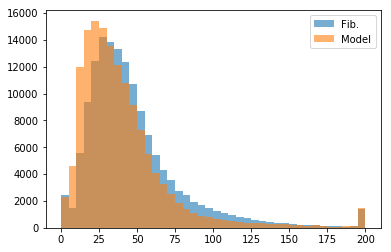

In [154]:
if test_length == 0:
    plt.hist(esmape_Y_fib, bins=40, alpha=0.6, label='Fib.')
    plt.hist(esmape_Y_pred, bins=40, alpha=0.6, label='Model')
    #plt.yscale('log')
    plt.legend(); plt.show()

### Page Scores in Each Group

In [155]:
if test_length:  # The model
    smape_Y_pred_list_ens = []
    for smape_Y_pred in smape_Y_pred_ens:
        smape_Y_pred_list = [smape_Y_pred[output_gp == gp] for gp in gp_list]
        smape_Y_pred_list_ens.append(smape_Y_pred_list)

In [156]:
if test_length == 0:  # The model
    esmape_Y_pred_list_ens = []
    for esmape_Y_pred in esmape_Y_pred_ens:
        esmape_Y_pred_list = [esmape_Y_pred[input_gp == gp] for gp in gp_list]
        esmape_Y_pred_list_ens.append(esmape_Y_pred_list)

In [157]:
if test_length:  # Fib.
    smape_Y_fib_list = [smape_Y_fib[output_gp == gp] for gp in gp_list]

In [158]:
if test_length == 0:  # Fib.
    esmape_Y_fib_list = [esmape_Y_fib[input_gp == gp] for gp in gp_list]

#### Plots

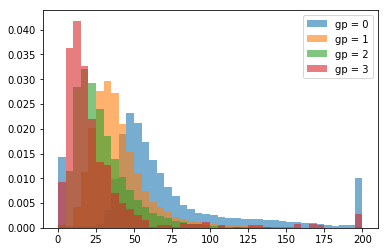

In [159]:
if test_length: S_Y = smape_Y_pred_list
else: S_Y = esmape_Y_pred_list
for gp,s in zip(gp_list, S_Y):
    plt.hist(s, bins=40, normed=True, alpha=0.6, label='gp = ' + str(gp))
#plt.yscale('log')
plt.legend(); plt.show()

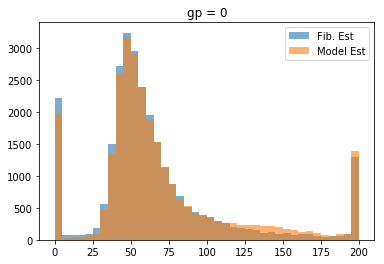

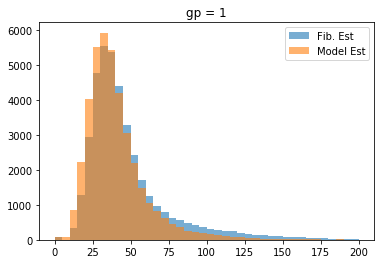

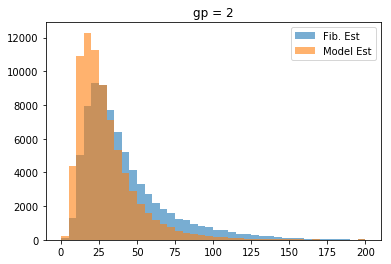

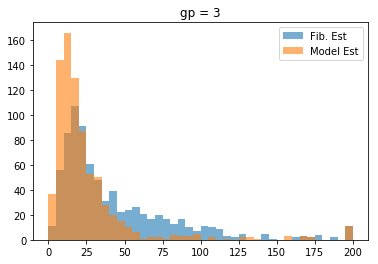

In [160]:
for gp in gp_list:
    if test_length:
        plt.hist(smape_Y_fib_list[gp], bins=40, alpha=0.6, label='Fib.')
        plt.hist(smape_Y_pred_list[gp], bins=40, alpha=0.6, label='Model')
    else:
        plt.hist(esmape_Y_fib_list[gp], bins=40, alpha=0.6, label='Fib. Est')
        plt.hist(esmape_Y_pred_list[gp], bins=40, alpha=0.6, label='Model Est')
    plt.title('gp = '+str(gp)); plt.legend()
    plt.show()

## Prediction Pre Combine
Combine group 0, 1 from Fib and rest from the model

Y_output_fib.shape

In [161]:
Y_output_fib_ori = np.repeat(Y_output_fib, y_length, axis=1); Y_output_fib_ori.shape

(145063, 64)

In [162]:
Y_input_fib_ori = np.repeat(Y_input_fib, y_length, axis=1); Y_input_fib_ori.shape

(145063, 64)

In [163]:
# Select group 0 from Fib.
fib_mask = (output_gp == 0).reshape(-1,1); fib_mask.shape
#fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [164]:
# The combined result
Y_output_fmc_ori_ens = []
for Y_output_pred_ori in Y_output_pred_ori_ens:
    
    Y_output_fmc_ori = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori
    
    Y_output_fmc_ori_ens.append(Y_output_fmc_ori)

In [165]:
# The combined result for input set
Y_input_fmc_ori_ens = []
for Y_input_pred_ori in Y_input_pred_ori_ens:
    
    Y_input_fmc_ori = fib_mask * Y_input_fib_ori + (~fib_mask) * Y_input_pred_ori
    
    Y_input_fmc_ori_ens.append(Y_input_fmc_ori)

Y_output_fmc_ori

#### Pre Combined Score

In [166]:
if test_length: 
    fmc_smape_ens = []
    for Y_output_fmc_ori in Y_output_fmc_ori_ens:
        fmc_smape = smape(Y_output_fmc_ori, Y_output_raw)
        fmc_smape_ens.append(fmc_smape)        
    fmc_smape_ens_mean = np.mean(fmc_smape_ens)

In [167]:
fmc_esmape_ens = []
for Y_input_fmc_ori in Y_input_fmc_ori_ens:
    fmc_esmape = esmape(Y_input_fmc_ori, Y_input_raw)
    fmc_esmape_ens.append(fmc_esmape)        
fmc_esmape_ens_mean = np.mean(fmc_esmape_ens)

In [168]:
if test_length: 
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')

In [169]:
for run, fmc_esmape, model_esmape in zip(ens_list, fmc_esmape_ens, model_esmape_ens):
    print('%6.3f' % fmc_esmape, '(%6.3f)' % model_esmape, '-', model_name, 'Est', run)
print('%6.3f' % fmc_esmape_ens_mean, '(%6.3f)' % model_esmape_ens_mean, '-', model_name, 'Est', 'Average')

39.059 (39.265) - model_10_Modified_CNN_7_More_Neurons-Stage_2_Predict Est 0
39.055 (39.300) - model_10_Modified_CNN_7_More_Neurons-Stage_2_Predict Est 1
39.122 (39.360) - model_10_Modified_CNN_7_More_Neurons-Stage_2_Predict Est 2
38.896 (39.146) - model_10_Modified_CNN_7_More_Neurons-Stage_2_Predict Est 3
39.098 (39.389) - model_10_Modified_CNN_7_More_Neurons-Stage_2_Predict Est 4
39.046 (39.292) - model_10_Modified_CNN_7_More_Neurons-Stage_2_Predict Est Average


## Ensemble Learning

### Ensemble Median

In [170]:
Y_output_pred_ori_ens_med = np.median(Y_output_pred_ori_ens, axis=0)
Y_output_pred_ori_ens_med.shape

(145063, 64)

In [171]:
Y_input_pred_ori_ens_med = np.median(Y_input_pred_ori_ens, axis=0)
Y_input_pred_ori_ens_med.shape

(145063, 64)

Y_output_pred_ori_ens_med

In [172]:
if test_length:
    ens_med_smape = smape(Y_output_pred_ori_ens_med, Y_output_raw); print(ens_med_smape)

In [173]:
ens_med_esmape = esmape(Y_input_pred_ori_ens_med, Y_input_raw); print(ens_med_esmape)

38.7179


Best ways seem to be taking median either before or after transformation.

### Ensemble Combine with Fibonacci Median

In [174]:
#Replace group 0 by Fib. Median
fib_mask = ((output_gp == 0)).reshape(-1,1); fib_mask.shape
#fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape

(145063, 1)

In [175]:
Y_output_f_omed  = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori_ens_med

In [176]:
Y_input_f_omed  = fib_mask * Y_input_fib_ori + (~fib_mask) * Y_input_pred_ori_ens_med

## All Model Scores

In [177]:
if test_length:  # Ensemble learning model score
    f_omed_smape = smape(Y_output_raw, Y_output_f_omed)

In [178]:
# Ensemble learning model estimated score
f_omed_esmape = esmape(Y_input_raw, Y_input_f_omed)

In [179]:
if test_length: # The_score with (without) combining Fibonacci median model
    print('%6.3f' % f_omed_smape, '(%6.3f)' % ens_med_smape,'-', model_name, 'ori_ensemble_median')
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)

In [180]:
# The Estimated score with (without) combining Fibonacci median model
print('%6.3f' % f_omed_esmape, '(%6.3f)' % ens_med_esmape,'-', model_name, 'Est', 'ori_ensemble_median')
print('%6.3f' % fmc_esmape_ens_mean, '(%6.3f)' % model_esmape_ens_mean, '-', model_name, 'Est', 'Average')
for run, fmc_esmape, model_esmape in zip(ens_list, fmc_esmape_ens, model_esmape_ens):
    print('%6.3f' % fmc_esmape, '(%6.3f)' % model_esmape, '-', model_name, 'Est', run)

38.516 (38.718) - model_10_Modified_CNN_7_More_Neurons-Stage_2_Predict Est ori_ensemble_median
39.046 (39.292) - model_10_Modified_CNN_7_More_Neurons-Stage_2_Predict Est Average
39.059 (39.265) - model_10_Modified_CNN_7_More_Neurons-Stage_2_Predict Est 0
39.055 (39.300) - model_10_Modified_CNN_7_More_Neurons-Stage_2_Predict Est 1
39.122 (39.360) - model_10_Modified_CNN_7_More_Neurons-Stage_2_Predict Est 2
38.896 (39.146) - model_10_Modified_CNN_7_More_Neurons-Stage_2_Predict Est 3
39.098 (39.389) - model_10_Modified_CNN_7_More_Neurons-Stage_2_Predict Est 4


37.429 (38.536) - model_10_Modified_CNN_4_The_Model ori_ensemble_median
37.731 (38.836) - model_10_Modified_CNN_4_The_Model Average
37.699 (38.826) - model_10_Modified_CNN_4_The_Model 0
37.623 (38.677) - model_10_Modified_CNN_4_The_Model 1
37.763 (38.829) - model_10_Modified_CNN_4_The_Model 2
37.748 (38.889) - model_10_Modified_CNN_4_The_Model 3
37.821 (38.957) - model_10_Modified_CNN_4_The_Model 4

37.436          - model_10_Modified_CNN_0_median_stdev ori_ens_mean
37.382          - model_10_Modified_CNN_0_median_stdev ori_ens_med
37.394          - model_10_Modified_CNN_0_median_stdev ens_mean_ori
37.382          - model_10_Modified_CNN_0_median_stdev ens_med_ori
37.687 (38.816) - model_10_Modified_CNN_0_median_stdev Average

Ensemble of model are all better than the individual model.

fmc_smape_ens

fmc_smape_ens_mean

#### Combined Scores:
37.473          - model_10_Modified_CNN_1_Z ori_ensemble_median

37.535          - model_10_Modified_CNN_0_median_stdev_2_3_groups ori_ensemble_median

37.382          - model_10_Modified_CNN_0_median_stdev ori_ens_med

37.687 (38.816) - model_10_Modified_CNN_0_median_stdev Average

38.734 (39.415) - Model 9.1.0 - model_9_CNN_with_Fibonacci_1_no_group 1

38.227 (39.321) - Model 9.0.0 - model_9_CNN_with_Fibonacci_0_separate_Fib_median 1

43.009 (44.180) - Model 7.8.0 - model_7_CNN_with_Fibonacci_8_mean_absolute_error 2

44.070 (45.335) - Model 7.6.3 - model_7_CNN_with_Fibonacci_6_Wider_3_conv_120_Averagepool 1

44.473 (45.652) - Model 7.6.1 - model_7_CNN_with_Fibonacci_6_Wider_1_conv_120_Maxpool 1

44.433 - Model 7.5.0 - model_7_CNN_with_Fibonacci_5_Deeper_0_Initial

44.168 - Model 7.2.0

## All Group Scores

In [181]:
# ensemble result Y_output in each group
Y_output_pred_ori_ens_med_list = [Y_output_pred_ori_ens_med[output_gp == gp] for gp in gp_list]

In [182]:
# ensemble result Y_input in each group
Y_input_pred_ori_ens_med_list = [Y_input_pred_ori_ens_med[input_gp == gp] for gp in gp_list]

In [183]:
# Group SMAPE scores
if test_length:
    # SMAPE with nan values ignored (used by Kaggle)
    gp_omed_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_ens_med_list)]

In [184]:
# Group Estimated SMAPE scores
gp_omed_esmape = [esmape(Y, Y_p) for Y, Y_p in zip(Y_input_raw_list, Y_input_pred_ori_ens_med_list)]

In [185]:
if test_length:  # The_gp_score
    print('#### ' + model_name)
    print('', end='|')
    print(' N_pages', 'Fibonacci', 'Ens Media', ' Average ', sep='|', end='|')
    for run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', '---------', sep='|', end='|')
    for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_output_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        #print(' %7.3f ' % gp_omean_smape[gp], end='|')
        print(' %7.3f ' % gp_omed_smape[gp], end='|')
        #print(' %7.3f ' % gp_meano_smape[gp], end='|')
        #print(' %7.3f ' % gp_medo_smape[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        for run in ens_list:
            print(' %7.3f ' % gp_smape_ens[run][gp], end='|')
        print('')
    print('|Over All', ' %7.3f ' % fib_smape, ' %7.3f ' % f_omed_smape,
          ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')
    for run in ens_list:
            print(' %7.3f ' % model_smape_ens[run], end='|')

# Note The over all score for ensemble median (Ens Media) is the one after combining with 
# Fibonacci median model not the total score

In [186]:
# The Estimated gp score
print('#### ' + model_name, 'Estimated')
print('', end='|')
print(' N_pages', 'Fibonacci', 'Ens Media', ' Average ', sep='|', end='|')
for run in ens_list: print(' Model', run, end=' |')
print('')
print('', end='|')
print('--------', '---------', '---------', '---------', sep='|', end='|')
for run in ens_list: print('---------', end='|')
print('')
for gp in gp_list:
    print('', end='|')
    print(' %6d ' % gp_input_n[gp], end='|')
    print(' %7.3f ' % gp_esmape_fib[gp], end='|')
    print(' %7.3f ' % gp_omed_esmape[gp], end='|')
    print(' %7.3f ' % gp_esmape_mean[gp], end='|')
    for run in ens_list:
        print(' %7.3f ' % gp_esmape_ens[run][gp], end='|')
    print('')
print('|Over All', ' %7.3f ' % fib_esmape, ' %7.3f ' % f_omed_esmape,
      ' %7.3f ' % model_esmape_ens_mean, sep='|', end='|')
for run in ens_list:
        print(' %7.3f ' % model_esmape_ens[run], end='|')

# Note The over all score for ensemble median (Ens Media) is the one after combining with 
# Fibonacci median model not the total score

#### model_10_Modified_CNN_7_More_Neurons-Stage_2_Predict Estimated
| N_pages|Fibonacci|Ens Media| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|
|  27413 |  67.261 |  70.198 |  70.400 |  70.083 |  70.499 |  70.311 |  70.435 |  70.675 |
|  40041 |  47.214 |  39.850 |  40.462 |  40.655 |  40.216 |  40.739 |  40.331 |  40.369 |
|  76815 |  41.531 |  28.954 |  29.610 |  29.552 |  29.717 |  29.620 |  29.404 |  29.756 |
|    794 |  41.575 |  22.280 |  23.707 |  23.971 |  24.223 |  23.294 |  23.472 |  23.576 |
|Over All|  47.328 |  38.516 |  39.292 |  39.265 |  39.300 |  39.360 |  39.146 |  39.389 |

#### model_10_Modified_CNN_4_The_Model
| N_pages|Fibonacci|Ens Media| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.304 |  68.291 |  68.432 |  67.965 |  68.039 |  68.527 |  68.492 |
|  43691 |  40.612 |  39.627 |  39.986 |  39.863 |  39.935 |  40.101 |  39.696 |  40.336 |
|  75617 |  34.284 |  29.275 |  29.633 |  29.641 |  29.453 |  29.630 |  29.832 |  29.606 |
|    791 |  34.653 |  33.112 |  33.308 |  33.714 |  33.951 |  32.934 |  33.296 |  32.647 |
|Over All|  40.404 |  37.429 |  38.836 |  38.826 |  38.677 |  38.829 |  38.889 |  38.957 |
#### model_10_Modified_CNN_0_median_stdev_2_3_groups
| N_pages|Fibonacci|Ens Media| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|
|  24964 |  61.170 |  68.909 |  68.900 |  69.367 |  69.103 |  69.194 |  69.001 |  67.833 |
|  43691 |  40.612 |  39.821 |  40.247 |  39.939 |  40.098 |  40.056 |  40.701 |  40.443 |
|  76408 |  34.288 |  29.400 |  29.910 |  29.979 |  30.039 |  29.790 |  29.676 |  30.068 |
|Over All|  40.404 |  37.535 |  39.140 |  39.154 |  39.194 |  39.062 |  39.169 |  39.119 |
#### model_10_Modified_CNN_0_median_stdev
| N_pages|Fibonacci| ori mean|ori media| mean ori|media ori| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 199.741 | 172.496 | 191.624 | 172.496 | 161.576 | 156.487 | 166.024 | 139.355 | 159.019 |
|  23085 |  61.354 |  64.110 |  64.122 |  64.116 |  64.122 |  64.389 |  64.273 |  64.008 |  63.988 |  64.148 |
|  43691 |  40.612 |  39.620 |  39.564 |  39.574 |  39.564 |  39.684 |  39.842 |  39.969 |  39.808 |  40.173 |
|  75617 |  34.284 |  29.300 |  29.231 |  29.248 |  29.231 |  29.538 |  29.575 |  29.454 |  29.907 |  29.573 |
|    740 |  35.621 |  33.403 |  33.482 |  33.373 |  33.482 |  33.564 |  33.710 |  33.397 |  33.666 |  33.965 |
|     51 |  20.224 |  16.360 |  16.338 |  16.361 |  16.338 |  16.406 |  16.451 |  17.309 |  16.628 |  16.331 |
#### model_9_CNN_with_Fibonacci_4_Ensemble_3_filter_3
| N_pages|Fibonacci| ori mean|ori media| mean ori|media ori| Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
|   1879 |  57.385 | 199.921 | 173.799 | 189.346 | 173.799 | 161.230 | 166.806 | 139.008 | 152.935 | 170.833 |
|  23085 |  61.354 |  63.635 |  63.651 |  63.644 |  63.651 |  64.048 |  63.281 |  63.966 |  63.664 |  63.569 |
|  43691 |  40.612 |  39.693 |  39.628 |  39.637 |  39.628 |  40.004 |  39.860 |  40.201 |  39.817 |  40.143 |
|  75617 |  34.284 |  29.444 |  29.368 |  29.381 |  29.368 |  30.201 |  29.582 |  29.611 |  29.744 |  29.618 |
|    740 |  35.621 |  33.858 |  33.893 |  33.837 |  33.893 |  33.801 |  34.143 |  34.101 |  34.290 |  34.145 |
|     51 |  20.224 |  16.861 |  16.948 |  16.856 |  16.948 |  16.933 |  17.094 |  16.930 |  17.424 |  16.985 |

## Optimize Group Models

### Group Models in other Groups

In [187]:
%%time
Y_output_all_ori_list_ens = unlog(np.array([[untransform(model.predict([X_output, A_output]), 
                                                         Y_output_center, output_scale) 
                                            for model in models] for models in models_ens]))
#Take 4 min on PC and NB

Wall time: 4min 23s


In [188]:
%%time
if test_length == 0:
    Y_input_all_ori_list_ens = unlog(np.array([[untransform(model.predict([X_input, A_input]), 
                                                         Y_input_center, input_scale) 
                                            for model in models] for models in models_ens]))
#Take 4 min on PC and NB

Wall time: 4min 20s


In [189]:
Y_output_all_ori_list_ens.shape  # (Ensemble, Group model, Y, y)

(5, 4, 145063, 64)

In [190]:
#Take Ensemble median
Y_output_all_ori_list_ens_med = np.median(Y_output_all_ori_list_ens, axis=0); Y_output_all_ori_list_ens_med.shape

(4, 145063, 64)

In [191]:
#Take Ensemble median for input set for estimation
if test_length == 0:
    Y_input_all_ori_list_ens_med = np.median(Y_input_all_ori_list_ens, axis=0); Y_input_all_ori_list_ens_med.shape

In [192]:
#Group scores for each group models
#row index: group model; column index: group of Y
if test_length:
    smape_gpm_gp_ens_med = [[smape(Y, Y_p[output_gp == gp]) for gp, Y in zip(gp_list, Y_output_raw_list)] 
                            for Y_p in Y_output_all_ori_list_ens_med]

In [193]:
#Group Est. scores for each group models
#row index: group model; column index: group of Y
if test_length == 0:
    esmape_gpm_gp_ens_med = [[esmape(Y, Y_p[input_gp == gp]) for gp, Y in zip(gp_list, Y_input_raw_list)] 
                            for Y_p in Y_input_all_ori_list_ens_med]

In [194]:
if test_length:
    print('Ens. Median   ', end='|')
    for j in range(len(smape_gpm_gp_ens_med[0])): print(' group', j, end='|')
    print('')
    print('--------------', end='|')
    for j in range(len(smape_gpm_gp_ens_med[0])): print('--------', end='|')
    print('')
    for i in range(len(smape_gpm_gp_ens_med)):
        print('group model', i, end=' |')
        for j in range(len(smape_gpm_gp_ens_med[0])):
            print(' %6.2f ' % smape_gpm_gp_ens_med[i][j], end='|')
        print('')
else:
    print('Ens. Median   ', end='|')
    for j in range(len(esmape_gpm_gp_ens_med[0])): print(' group', j, end='|')
    print('')
    print('--------------', end='|')
    for j in range(len(esmape_gpm_gp_ens_med[0])): print('--------', end='|')
    print('')
    for i in range(len(esmape_gpm_gp_ens_med)):
        print('group model', i, end=' |')
        for j in range(len(esmape_gpm_gp_ens_med[0])):
            print(' %6.2f ' % esmape_gpm_gp_ens_med[i][j], end='|')
        print('')

Ens. Median   | group 0| group 1| group 2| group 3|
--------------|--------|--------|--------|--------|
group model 0 |  70.20 |  47.26 |  41.56 |  41.58 |
group model 1 |  70.02 |  39.85 |  35.47 |  40.03 |
group model 2 |  72.84 |  44.15 |  28.95 |  30.25 |
group model 3 |  79.04 |  51.55 |  39.32 |  22.28 |


In [195]:
if test_length: 
    for x in gp_omed_smape: print(' %6.2f ' % x, end='|')
else: 
    for x in gp_omed_esmape: print(' %6.2f ' % x, end='|')

  70.20 |  39.85 |  28.95 |  22.28 |

In [196]:
if test_length: 
    for x in gp_smape_fib: print(' %6.2f ' % x, end='|')
else: 
    for x in gp_esmape_fib: print(' %6.2f ' % x, end='|')

  67.26 |  47.21 |  41.53 |  41.57 |

### Optimized Group Models

In [197]:
if test_length:
    gpm_list = np.argmin(smape_gpm_gp_ens_med,axis=0)
else:
    gpm_list = np.array([0,1,2,2])  # Select manually in prediction stage !!!

print(model_name,'gpm_list = [', end='')
for x in gpm_list: print(x, end=',')
print(']')

model_10_Modified_CNN_7_More_Neurons-Stage_2_Predict gpm_list = [0,1,2,2,]


In [198]:
gpm_mask = np.array([gpm_list == gp for gp in gp_list]).T; gpm_mask

array([[ True, False, False, False],
       [False,  True, False, False],
       [False, False,  True, False],
       [False, False,  True, False]], dtype=bool)

In [199]:
Y_output_ori_list_ens_med_temp = np.tensordot(gpm_mask, Y_output_all_ori_list_ens_med, axes=([1],[0]))

In [200]:
gp_mask = np.array([output_gp == gp for gp in gp_list]); gp_mask

array([[False, False,  True, ..., False,  True,  True],
       [ True,  True, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [201]:
gp_mask_reshape = gp_mask.reshape(len(gp_mask),len(gp_mask[0]),1); gp_mask_reshape.shape

(4, 145063, 1)

In [202]:
Y_output_ori_list_ens_med_temp_mask = gp_mask_reshape * Y_output_ori_list_ens_med_temp

In [203]:
Y_output_ori_list_ens_med_temp_mask.shape

(4, 145063, 64)

In [204]:
Y_output_gpm_ens_med = np.sum(Y_output_ori_list_ens_med_temp_mask, axis=0)

In [208]:
del Y_output_ori_list_ens_med_temp
del Y_output_ori_list_ens_med_temp_mask
gc.collect()  # save 300 MB

442

In [205]:
Y_output_gpm_ens_med.shape

(145063, 64)

In [206]:
if test_length: gpm_ens_smape = smape(Y_output_raw, Y_output_gpm_ens_med)

In [207]:
if test_length: print(gpm_ens_smape, ens_med_smape)

#### Group scores

In [209]:
Y_output_gpm_ens_med_list = [Y_output_gpm_ens_med[output_gp == gp] for gp in gp_list]

In [210]:
# Group SMAPE scores
if test_length:
    gp_gpm_ens_med_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_gpm_ens_med_list)]

In [211]:
if test_length:
    #print('#### ' + model_name + 'group model optimized')
    #print('', end='|')
    print(' N_pages', 'Fibonacci', 'GPM Optim', 'Ens Media', ' Average ', sep='|', end='|')
    #or run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', '---------', '---------', sep='|', end='|')
    #for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_output_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        print(' %7.3f ' % gp_gpm_ens_med_smape[gp], end='|')
        print(' %7.3f ' % gp_omed_smape[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        print('')
    #print('|Over All', ' %7.3f ' % fib_smape, ' %7.3f ' % f_omed_smape,
    #      ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')    
# Note The over all score for ensemble median (Ens Media) is the one after combining with 
# Fibonacci median model not the total score

#### Combined with Fib.

In [212]:
#Select group 0
#fib_mask = ((output_gp == 0)|(output_gp == 1)).reshape(-1,1); fib_mask.shape
fib_mask = (output_gp == 0).reshape(-1,1); fib_mask.shape

(145063, 1)

In [213]:
Y_output_f_gpm = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_gpm_ens_med  # Our final output

In [214]:
if test_length: f_gpm_ens_smape = smape(Y_output_raw, Y_output_f_gpm)
if test_length: print('%6.3f' % f_gpm_ens_smape, '(%6.3f)' % gpm_ens_smape, '-', model_name, 'GPM Optim Ens')

## Plots

### Group model examination

In [215]:
Y_output_all_ori_list_ens_med.shape

(4, 145063, 64)

#### Group = 1

In [216]:
gp = 1
Y_list = Y_output_all_ori_list_ens_med[:, output_gp == gp]

In [217]:
Y_list.shape

(4, 43804, 64)

In [218]:
view_list = np.sort(np.random.choice(len(Y_list[0]), 5, replace=False)); view_list

array([12144, 21523, 31347, 35215, 43624])

Group 1
i =  12144


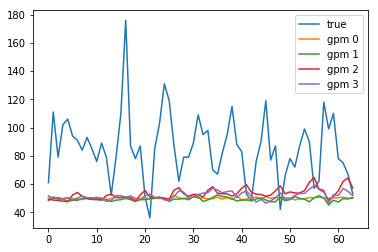

i =  21523


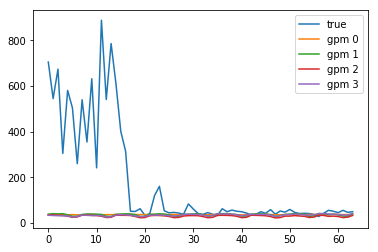

i =  31347


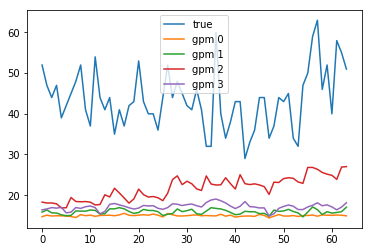

i =  35215


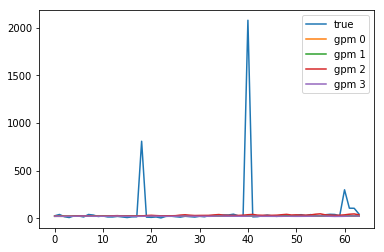

i =  43624


IndexError: index 43624 is out of bounds for axis 0 with size 40041

In [219]:
print('Group ' + str(gp))
for i in view_list:
    print('i = ', i)
    if test_length: plt.plot(Y_output_ori_list[gp][i], label='true')
    else: plt.plot(X_output_ori_list[gp][i], label='true')
    for gpm in gp_list:
        plt.plot(Y_list[gpm, i], label='gpm '+ str(gpm))
    plt.legend()
    plt.show()    

In [220]:
orinal_view_list = np.arange(len(output_gp))[output_gp == gp][view_list];
np.array([view_list, orinal_view_list])

array([[ 12144,  21523,  31347,  35215,  43624],
       [ 36267,  69899, 113870, 126305, 144668]])

In [221]:
np.array([fib_input_median[orinal_view_list], fib_output_median[orinal_view_list]])

array([[  34.  ,  265.25,   15.5 ,   12.5 ,   23.  ],
       [  50.  ,   37.25,   15.  ,   23.75,   35.5 ]], dtype=float32)

#### Group = 2

In [222]:
gp = 2
Y_list = Y_output_all_ori_list_ens_med[:, output_gp == gp]

In [223]:
Y_list.shape

(4, 74588, 64)

In [224]:
view_list = np.sort(np.random.choice(len(Y_list[0]), 5, replace=False)); view_list

array([ 3929,  6730,  9407, 37971, 67902])

Group 2
i =  3929


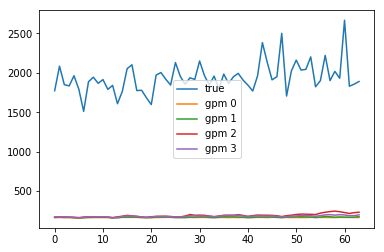

i =  6730


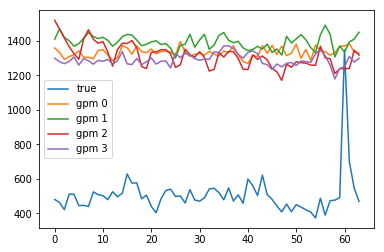

i =  9407


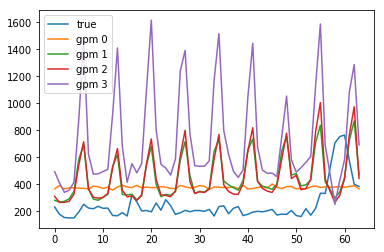

i =  37971


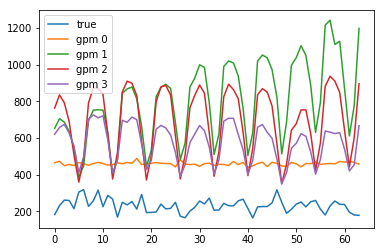

i =  67902


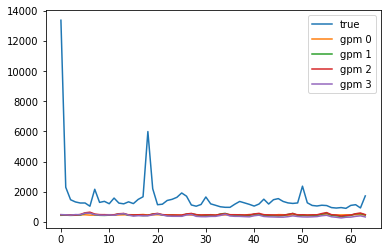

In [225]:
print('Group ' + str(gp))
for i in view_list:
    print('i = ', i)
    if test_length: plt.plot(Y_output_ori_list[gp][i], label='true')
    else: plt.plot(X_output_ori_list[gp][i], label='true')
    for gpm in gp_list:
        plt.plot(Y_list[gpm, i], label='gpm '+ str(gpm))
    plt.legend()
    plt.show()    

In [226]:
orinal_view_list = np.arange(len(output_gp))[output_gp == gp][view_list];
np.array([view_list, orinal_view_list])

array([[  3929,   6730,   9407,  37971,  67902],
       [  9888,  13097,  18906,  71895, 121290]])

In [227]:
np.array([fib_input_median[orinal_view_list], fib_output_median[orinal_view_list]])

array([[  501.75,  1360.5 ,   274.5 ,   578.25,   369.5 ],
       [  166.  ,  1334.  ,   377.  ,   460.5 ,   469.25]], dtype=float32)

#### Case 131296

In [229]:
i = 131296

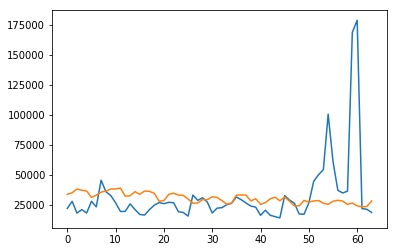

In [230]:
if test_length: multi_view((Y_output_ori[i],Y_output_pred_ori[i]))
else: multi_view((X_output_ori[i],Y_output_pred_ori[i]))

### Cases study

In [231]:
view_list=[93175, 13986, 5464, 89589, 119659, 64392, 73856, 140331, 19234, 25591]

view_list = examine_list_gp((Y_output_ori,
                             Y_output_pred_ori_ens_mean, 
                             Y_output_pred_ori_ens_med,
                             Y_output_pred_ori_ens[-1], 
                             ), output_gp, view_list=view_list)

i = 93175
plt.plot(Y_output_ori[i], label='true')
for run in ens_list:
    plt.plot(Y_output_pred_ori_ens[run][i], label='run' + str(run))
plt.plot(Y_output_pred_ens_mean_ori[i], label='ens mean before transf')
plt.title('i = ' + str(i) + ' gp = ' + str(output_gp[i]))
plt.legend()
plt.show()

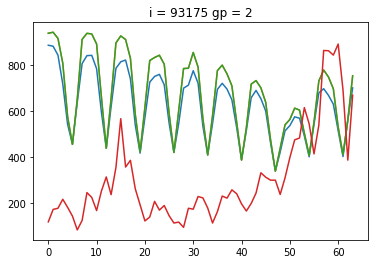

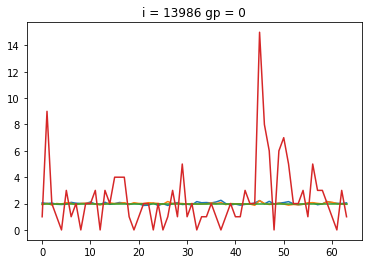

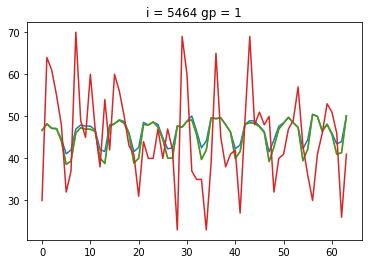

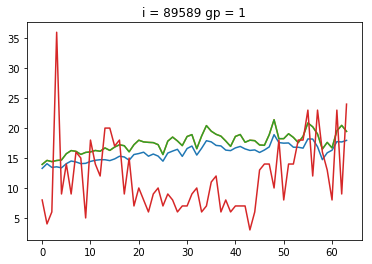

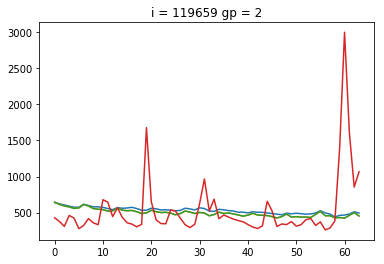

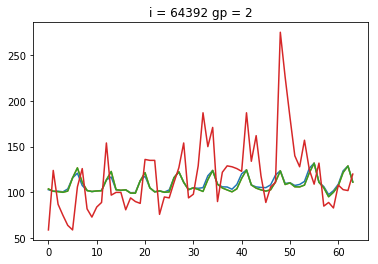

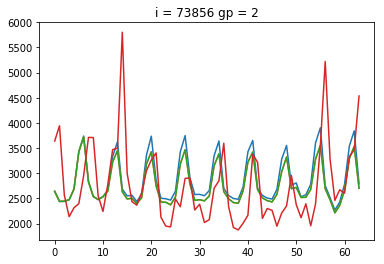

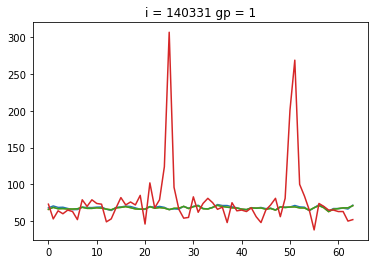

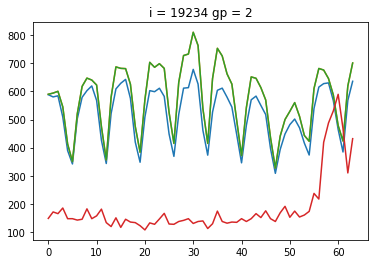

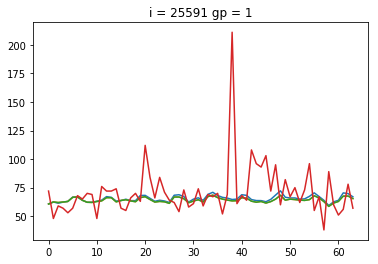

In [232]:
if test_length:
    view_list = examine_list_gp((Y_output_pred_ori_ens[-1], 
                                 Y_output_pred_ori_ens_med,
                                 Y_output_f_gpm, 
                                 Y_output_ori), output_gp, view_list=view_list)
else:
    view_list = examine_list_gp((Y_output_pred_ori_ens[-1], 
                                 Y_output_pred_ori_ens_med,
                                 Y_output_f_gpm, 
                                 X_output_ori), output_gp, view_list=view_list)

view_list = comp_examine(X_output, Y_output_pred, view_list=view_list)

view_list = comp_examine(X_output_ori, Y_output_pred_ori, view_list=view_list)

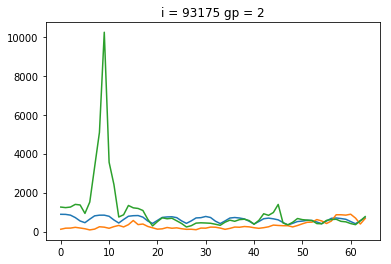

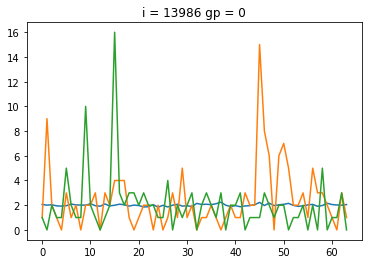

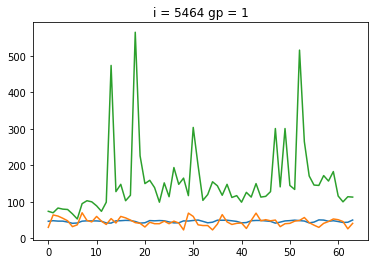

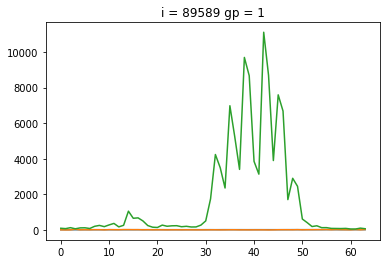

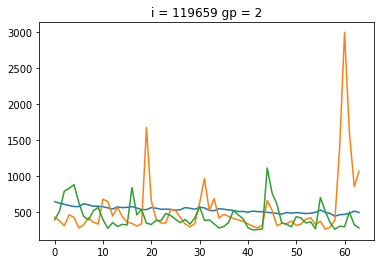

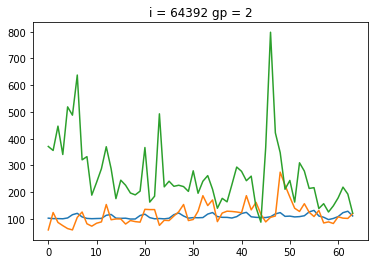

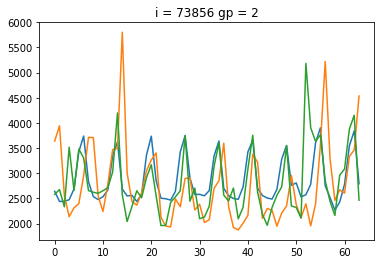

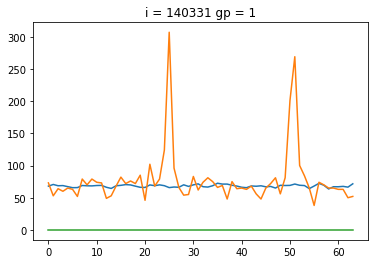

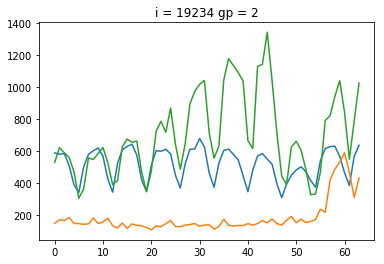

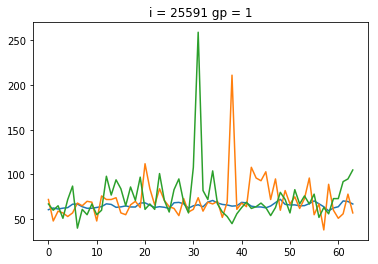

In [233]:
view_list = examine_list_gp((Y_output_pred_ori, X_output_ori, Y_input_ori), output_gp, view_list=view_list)

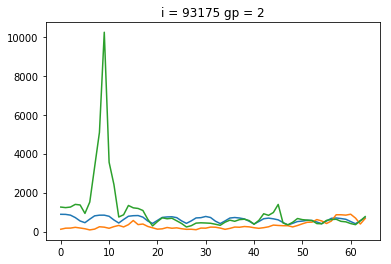

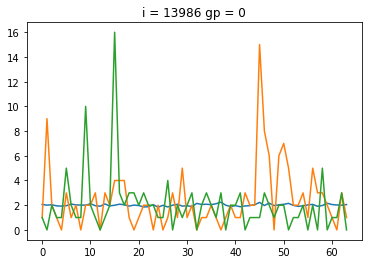

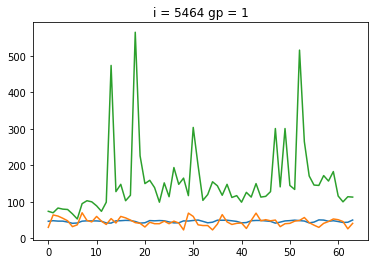

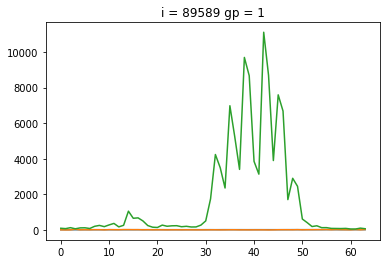

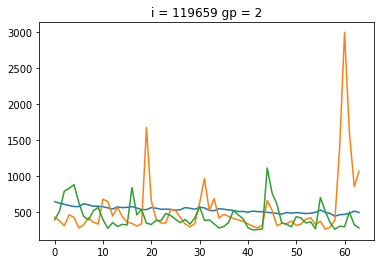

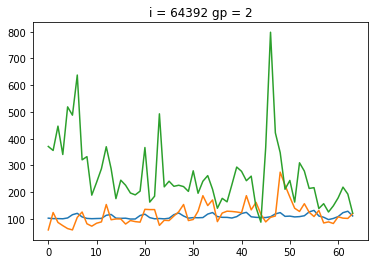

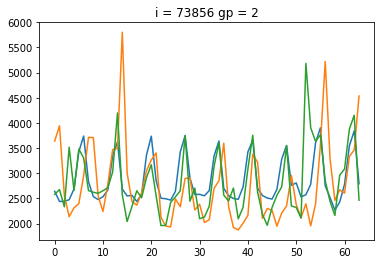

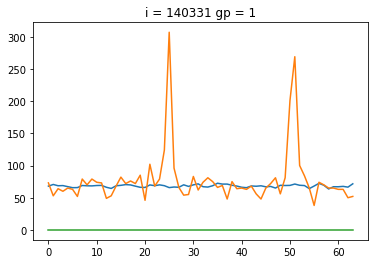

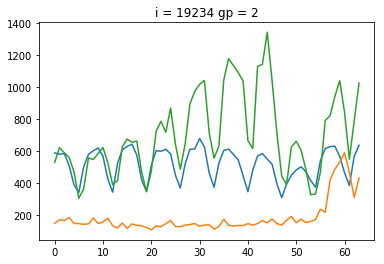

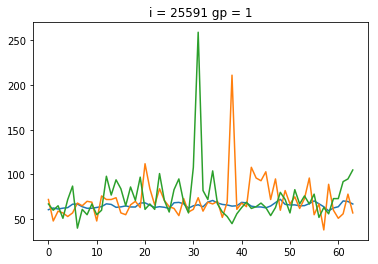

In [234]:
view_list = examine_list_gp((Y_output_pred_ori, X_output_ori, Y_input_ori), output_gp, view_list=view_list)

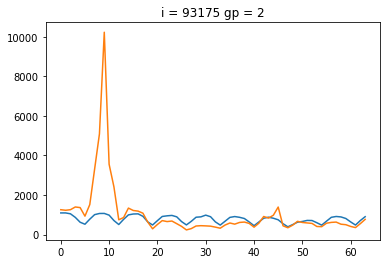

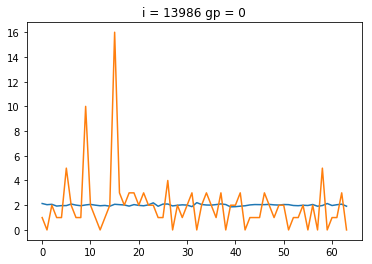

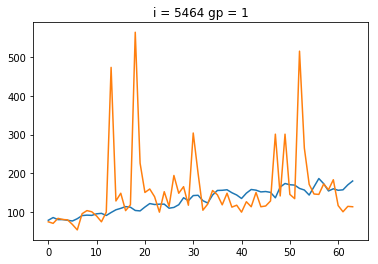

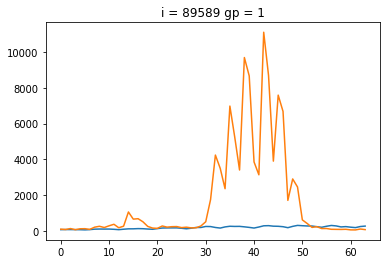

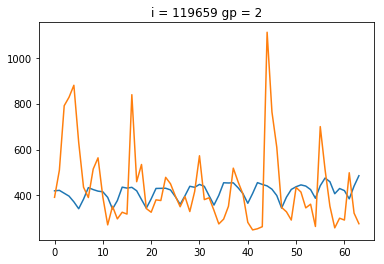

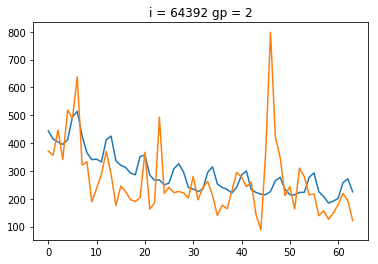

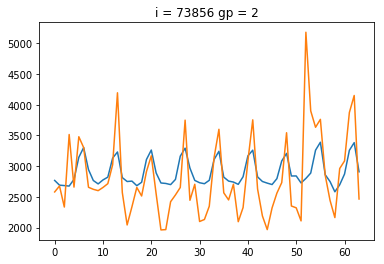

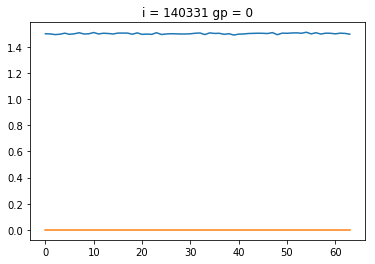

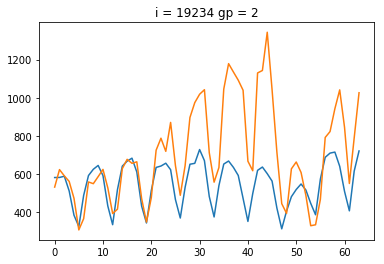

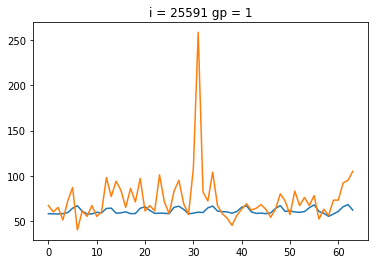

In [235]:
view_list = examine_list_gp((Y_input_pred_ori, Y_input_ori), input_gp, view_list=view_list)

view_list = examine_list_gp((Y_output_pred, X_output, Y_input), output_gp, view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred, Y_output, X_output), view_list=view_list)

if test_length:
    view_list = examine_list((Y_output_pred_ori, Y_output_ori, X_output_ori), view_list=view_list)

if test_length:
    view_list = examine_list_gp((Y_output_pred, Y_output, X_output), output_gp,
                             view_list=view_list)

if test_length:
    view_list = examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
                             view_list=view_list)

view_list_smape = [smape(Y_output_pred_ori[i], Y_output_raw[i]) for i in view_list]; view_list_smape

view_list_review = [score < model_smape for score in view_list_smape]; view_list_review

view_list_good = list(np.array(view_list)[view_list_review]); view_list_good

view_list_bad = list(np.array(view_list)[~np.array(view_list_review)]); view_list_bad

#### Good cases

examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori), output_gp,
             view_list=view_list_good)

#### Bad cases

examine_list_gp((Y_output_pred_ori, Y_output_ori, X_output_ori),output_gp,
             view_list=view_list_bad)

print(Y_output_center[view_list_good].reshape(-1))
print(Y_output_center[view_list_bad].reshape(-1))

print(output_scale[view_list_good].reshape(-1))
print(output_scale[view_list_bad].reshape(-1))

output_gp[view_list_good]

output_gp[view_list_bad]

#### Case 93175

i = 93175

multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]), yscale='log')
multi_view((Y_output_pred_ori[i], Y_output_ori[i], X_output_ori[i]))

smape(Y_output_pred_ori[i], Y_output_raw[i])

Y_input_center[i], Y_output_center[i], input_scale[i], output_scale[i]

#### Case 41896

i = 41896

multi_view((X_input[i], Y_input[i]))

comp_view(X_input_ori[i], Y_input_ori[i])

comp_view(X_output_ori[i], Y_output_pred_ori[i])

comp_view(X_input_ori[i], Y_input_ori[i])

### Good and bad cases

review_Y = np.array([score < model_smape for score in smape_Y_pred])
good_Y_index = np.arange(len(Y_output_pred))[review_Y]; #good_Y_index
bad_Y_index = np.arange(len(Y_output_pred))[~review_Y]; #bad_Y_index

good_input_scale = input_scale[good_Y_index]
good_output_scale = output_scale[good_Y_index]
bad_input_scale = input_scale[bad_Y_index]
bad_output_scale = output_scale[bad_Y_index]

good_Y_input_center = Y_input_center[good_Y_index]
good_Y_output_center = Y_output_center[good_Y_index]
bad_Y_input_center = Y_input_center[bad_Y_index]
bad_Y_output_center = Y_output_center[bad_Y_index]

examine_list_gp((Y_output_pred_ori[good_Y_index], Y_output_ori[good_Y_index], X_output_ori[good_Y_index]), output_gp[good_Y_index])

examine_list_gp((Y_output_pred_ori[bad_Y_index], Y_output_ori[bad_Y_index], X_output_ori[bad_Y_index]), output_gp[bad_Y_index])

good_output_scale.min(), good_output_scale.max()

bad_output_scale.min(), bad_output_scale.max()

plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.hist(good_input_scale, bins=40, alpha=0.6, label='good input')
plt.hist(bad_input_scale, bins=40, alpha=0.6, label='bad input')
plt.yscale('log')
plt.legend()
plt.show()

plt.hist(good_output_scale, bins=40, alpha=0.6, label='good output')
plt.hist(bad_output_scale, bins=40, alpha=0.6, label='bad output')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.hist(good_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='good input')
plt.hist(good_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='good output')
plt.hist(bad_input_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=100, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

Should we split the data into std > and < 1.7 ?

np.mean(good_output_scale), np.mean(good_input_scale)

np.mean(bad_output_scale), np.mean(bad_input_scale)

plt.figure(figsize=(12,4))
plt.hist(bad_input_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad input')
plt.hist(bad_output_scale, bins=60, range=(0,0.8), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.hist(output_scale, bins=40, alpha=0.6, label='output')
plt.hist(input_scale, bins=40, alpha=0.6, label='input')
plt.legend()
plt.show()

np.histogram(output_scale, bins=np.arange(0,1,0.05))

#### Median

plt.figure(figsize=(12,4))
plt.hist(good_Y_input_center, bins=100, range=(0,5), alpha=0.6, label='good input')
plt.hist(good_Y_output_center, bins=100, range=(0,5), alpha=0.6, label='good output')
plt.hist(bad_Y_input_center, bins=100, range=(0,5), alpha=0.6, label='bad input')
plt.hist(bad_Y_output_center, bins=100, range=(0,5), alpha=0.6, label='bad output')
plt.yscale('linear')
plt.legend()
plt.show()

### stdev/median

output_factor_1 = (Y_output_center / output_scale).reshape(-1); output_factor_1

output_factor_1.min(), output_factor_1.max()

plt.hist(output_factor_1, bins=40, range=[0,50], alpha=0.6)
plt.show()

plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, Y_output_center, alpha=0.1, marker='.')
plt.ylim([-0.1,5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_scale, alpha=0.1, marker='.')
plt.ylim([0,0.5])
plt.show()

plt.figure(figsize=(12,9))
plt.scatter(output_scale, Y_output_center, alpha=0.1, marker='.')
plt.ylim([0,4.5])
plt.xlim([0,0.6])
plt.show()

output_factor_2 = (output_scale / Y_output_center).reshape(-1); output_factor_2

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_2, alpha=0.1, marker='.')
plt.ylim([0,0.8])
#plt.xlim([0,0.6])
plt.show()

output_factor_3 = (output_scale / (Y_output_center + 0.01)).reshape(-1); output_factor_3

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_3, alpha=0.1, marker='.')
plt.ylim([0,4])
#plt.xlim([0,0.6])
plt.show()

output_factor_4 = output_scale - input_scale

plt.figure(figsize=(12,9))
plt.scatter(smape_Y_pred, output_factor_4, alpha=0.1, marker='.')
plt.ylim([-1.5,0.5])
#plt.xlim([0,0.6])
plt.show()

### Free some memory

In [236]:
del Y_input_pred
del Y_input_pred_ori
del Y_input_pred_ori_ens
del Y_input_pred_ori_ens_med
del Y_input_fib_ori
del Y_input_fmc_ori
del Y_input_f_omed
#del Y_input_all_ori_list_ens
del Y_input_all_ori_list_ens_med
gc.collect()

278446

In [237]:
del Y_output_gpm_ens_med_list

In [238]:
if test_length == 0:
    del Y_input_all_ori_list_ens
    gc.collect()

In [242]:
Y_output_all_ori_list_ens.shape

(5, 4, 145063, 64)

In [243]:
del Y_output_all_ori_list_ens  # ~700 MB
gc.collect()

In [246]:
del Y_list  #~100MB
gc.collect()

0

In [247]:
%whos ndarray

Variable                        Type       Data/Info
----------------------------------------------------
A                               ndarray    794x2: 1588 elems, type `float32`, 6352 bytes
A_input                         ndarray    145063x2: 290126 elems, type `float32`, 1160504 bytes (1.1067428588867188 Mb)
A_output                        ndarray    145063x2: 290126 elems, type `float32`, 1160504 bytes (1.1067428588867188 Mb)
X                               ndarray    794x64: 50816 elems, type `float32`, 203264 bytes (198.5 kb)
X_input                         ndarray    145063x64: 9284032 elems, type `float32`, 37136128 bytes (35.415771484375 Mb)
X_input_center                  ndarray    145063x1: 145063 elems, type `float32`, 580252 bytes (566.65234375 kb)
X_input_log                     ndarray    145063x64: 9284032 elems, type `float32`, 37136128 bytes (35.415771484375 Mb)
X_input_num                     ndarray    145063x64: 9284032 elems, type `float32`, 37136128 bytes (35

## Output Prediction
For predicting stage only

This part uses additional 4131 MB of memory !!!

### Result DataFrame

predict_dates_index=pd.date_range(Y_output_first_day, 
                                  periods=np.timedelta64(y_length,'D'), 
                                  freq = 'D', unit = 'D')
predict_dates_index

In [248]:
Y_output_dates

Index(['2017-09-11', '2017-09-12', '2017-09-13', '2017-09-14', '2017-09-15',
       '2017-09-16', '2017-09-17', '2017-09-18', '2017-09-19', '2017-09-20',
       '2017-09-21', '2017-09-22', '2017-09-23', '2017-09-24', '2017-09-25',
       '2017-09-26', '2017-09-27', '2017-09-28', '2017-09-29', '2017-09-30',
       '2017-10-01', '2017-10-02', '2017-10-03', '2017-10-04', '2017-10-05',
       '2017-10-06', '2017-10-07', '2017-10-08', '2017-10-09', '2017-10-10',
       '2017-10-11', '2017-10-12', '2017-10-13', '2017-10-14', '2017-10-15',
       '2017-10-16', '2017-10-17', '2017-10-18', '2017-10-19', '2017-10-20',
       '2017-10-21', '2017-10-22', '2017-10-23', '2017-10-24', '2017-10-25',
       '2017-10-26', '2017-10-27', '2017-10-28', '2017-10-29', '2017-10-30',
       '2017-10-31', '2017-11-01', '2017-11-02', '2017-11-03', '2017-11-04',
       '2017-11-05', '2017-11-06', '2017-11-07', '2017-11-08', '2017-11-09',
       '2017-11-10', '2017-11-11', '2017-11-12', '2017-11-13'],
      dtype=

In [249]:
if test_length == 0:
    result_df = pd.DataFrame(Y_output_f_gpm, columns = Y_output_dates)  # using ensemble median combined result
result_df  # Not using too much memory

,2017-09-11,2017-09-12,2017-09-13,2017-09-14,2017-09-15,2017-09-16,2017-09-17,2017-09-18,2017-09-19,2017-09-20,...,2017-11-04,2017-11-05,2017-11-06,2017-11-07,2017-11-08,2017-11-09,2017-11-10,2017-11-11,2017-11-12,2017-11-13
0,25.825024,26.818911,25.812914,25.635790,25.554226,26.887896,28.368406,28.538710,28.210323,28.288361,...,34.737846,38.747498,38.739414,36.337334,32.474575,34.123394,33.802208,36.016491,38.214966,37.967415
1,22.426901,24.033787,22.684263,23.080915,22.562706,22.852160,23.343582,24.623016,24.213451,24.371714,...,21.728779,24.133905,25.495296,23.242060,20.307369,22.220665,21.508852,24.041786,23.290010,24.609726
2,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,...,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000
3,14.853606,16.056816,15.155903,15.188747,14.661768,14.514758,15.062943,15.646559,15.395397,15.439451,...,15.317093,17.510759,17.986170,16.136015,14.156040,15.480642,15.837837,17.898544,18.234365,17.717463
4,12.818324,13.810644,12.928274,13.130486,12.827790,13.036863,12.967743,13.198027,12.785852,12.966063,...,11.982369,13.265903,13.325438,12.216738,10.394008,11.548359,11.686214,13.235216,12.757871,13.240339
5,15.237318,15.888424,15.185572,15.344437,15.482212,16.291315,16.409262,15.958220,15.363178,15.420225,...,15.705564,17.242424,16.992121,15.633066,13.641189,14.979966,15.211876,17.213594,16.879107,16.807760
6,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
7,34.639366,39.046127,35.913727,36.941620,37.200352,37.828857,37.646423,40.073990,38.819027,39.355083,...,33.975456,40.739597,48.089844,41.575073,33.493813,38.529358,36.649414,41.431419,40.742645,46.230324
8,37.740974,39.346779,37.980305,38.306438,38.330357,40.590816,40.339375,40.308723,38.893932,38.842979,...,41.191544,44.521252,44.449776,41.845638,37.502075,40.176193,40.372158,44.995205,44.091427,44.807400
9,26.860832,27.972904,27.463152,27.766939,25.629284,22.646671,23.887032,26.870892,27.280731,26.903055,...,22.368933,24.331686,28.425648,27.349407,24.224819,25.938360,24.751886,23.654123,24.006056,27.981852


In [250]:
result_df['Page'] = input_df['Page']  # Append 'Page' column from input_df
result_df

,2017-09-11,2017-09-12,2017-09-13,2017-09-14,2017-09-15,2017-09-16,2017-09-17,2017-09-18,2017-09-19,2017-09-20,...,2017-11-05,2017-11-06,2017-11-07,2017-11-08,2017-11-09,2017-11-10,2017-11-11,2017-11-12,2017-11-13,Page
0,25.825024,26.818911,25.812914,25.635790,25.554226,26.887896,28.368406,28.538710,28.210323,28.288361,...,38.747498,38.739414,36.337334,32.474575,34.123394,33.802208,36.016491,38.214966,37.967415,2NE1_zh.wikipedia.org_all-access_spider
1,22.426901,24.033787,22.684263,23.080915,22.562706,22.852160,23.343582,24.623016,24.213451,24.371714,...,24.133905,25.495296,23.242060,20.307369,22.220665,21.508852,24.041786,23.290010,24.609726,2PM_zh.wikipedia.org_all-access_spider
2,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,...,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,4.250000,3C_zh.wikipedia.org_all-access_spider
3,14.853606,16.056816,15.155903,15.188747,14.661768,14.514758,15.062943,15.646559,15.395397,15.439451,...,17.510759,17.986170,16.136015,14.156040,15.480642,15.837837,17.898544,18.234365,17.717463,4minute_zh.wikipedia.org_all-access_spider
4,12.818324,13.810644,12.928274,13.130486,12.827790,13.036863,12.967743,13.198027,12.785852,12.966063,...,13.265903,13.325438,12.216738,10.394008,11.548359,11.686214,13.235216,12.757871,13.240339,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...
5,15.237318,15.888424,15.185572,15.344437,15.482212,16.291315,16.409262,15.958220,15.363178,15.420225,...,17.242424,16.992121,15.633066,13.641189,14.979966,15.211876,17.213594,16.879107,16.807760,5566_zh.wikipedia.org_all-access_spider
6,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,91Days_zh.wikipedia.org_all-access_spider
7,34.639366,39.046127,35.913727,36.941620,37.200352,37.828857,37.646423,40.073990,38.819027,39.355083,...,40.739597,48.089844,41.575073,33.493813,38.529358,36.649414,41.431419,40.742645,46.230324,A'N'D_zh.wikipedia.org_all-access_spider
8,37.740974,39.346779,37.980305,38.306438,38.330357,40.590816,40.339375,40.308723,38.893932,38.842979,...,44.521252,44.449776,41.845638,37.502075,40.176193,40.372158,44.995205,44.091427,44.807400,AKB48_zh.wikipedia.org_all-access_spider
9,26.860832,27.972904,27.463152,27.766939,25.629284,22.646671,23.887032,26.870892,27.280731,26.903055,...,24.331686,28.425648,27.349407,24.224819,25.938360,24.751886,23.654123,24.006056,27.981852,ASCII_zh.wikipedia.org_all-access_spider


In [251]:
result_flat_df = pd.melt(result_df, id_vars='Page', var_name='date',
                         value_name='Visits')  #183 MB
result_flat_df

,Page,date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2017-09-11,25.825024
1,2PM_zh.wikipedia.org_all-access_spider,2017-09-11,22.426901
2,3C_zh.wikipedia.org_all-access_spider,2017-09-11,4.250000
3,4minute_zh.wikipedia.org_all-access_spider,2017-09-11,14.853606
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2017-09-11,12.818324
5,5566_zh.wikipedia.org_all-access_spider,2017-09-11,15.237318
6,91Days_zh.wikipedia.org_all-access_spider,2017-09-11,8.000000
7,A'N'D_zh.wikipedia.org_all-access_spider,2017-09-11,34.639366
8,AKB48_zh.wikipedia.org_all-access_spider,2017-09-11,37.740974
9,ASCII_zh.wikipedia.org_all-access_spider,2017-09-11,26.860832


### Output DataFrame

In [252]:
key_file

'key_2.csv'

In [253]:
if test_length == 0:  # Take 2118 MB of memory
    print('%%% Reading data ', key_file, '...', end = '', flush = True)
    output_df = pd.read_csv('../data/' + key_file)
    print('done!')

%%% Reading data  key_2.csv ...done!


Make sure your memory has about 2GB left before continuing!!!

In [254]:
# Use additional memory: Peak 1830 MB! In the end 468 MB.
output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
#output_df['date'] = output_df['date'].astype('datetime64[ns]')  # convert 'date' string to numpy datetime format
#test['weekday'] = test.date.dt.dayofweek  # find the day of week using the 'date' column
output_df.head()

,Page,Id,date
0,007_スペクター_ja.wikipedia.org_all-access_all-agents,0b293039387a,2017-09-13
1,007_スペクター_ja.wikipedia.org_all-access_all-agents,7114389dd824,2017-09-14
2,007_スペクター_ja.wikipedia.org_all-access_all-agents,057b02ff1f09,2017-09-15
3,007_スペクター_ja.wikipedia.org_all-access_all-agents,bd2aca21caa3,2017-09-16
4,007_スペクター_ja.wikipedia.org_all-access_all-agents,c0effb42cdd5,2017-09-17


In [255]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8993906 entries, 0 to 8993905
Data columns (total 3 columns):
Page    object
Id      object
date    object
dtypes: object(3)
memory usage: 205.9+ MB


In [256]:
output_df['date'].values[0:65]  # Make sure the range is 60 days (see if the dates resume after 60)

array(['2017-09-13', '2017-09-14', '2017-09-15', '2017-09-16',
       '2017-09-17', '2017-09-18', '2017-09-19', '2017-09-20',
       '2017-09-21', '2017-09-22', '2017-09-23', '2017-09-24',
       '2017-09-25', '2017-09-26', '2017-09-27', '2017-09-28',
       '2017-09-29', '2017-09-30', '2017-10-01', '2017-10-02',
       '2017-10-03', '2017-10-04', '2017-10-05', '2017-10-06',
       '2017-10-07', '2017-10-08', '2017-10-09', '2017-10-10',
       '2017-10-11', '2017-10-12', '2017-10-13', '2017-10-14',
       '2017-10-15', '2017-10-16', '2017-10-17', '2017-10-18',
       '2017-10-19', '2017-10-20', '2017-10-21', '2017-10-22',
       '2017-10-23', '2017-10-24', '2017-10-25', '2017-10-26',
       '2017-10-27', '2017-10-28', '2017-10-29', '2017-10-30',
       '2017-10-31', '2017-11-01', '2017-11-02', '2017-11-03',
       '2017-11-04', '2017-11-05', '2017-11-06', '2017-11-07',
       '2017-11-08', '2017-11-09', '2017-11-10', '2017-11-11',
       '2017-11-12', '2017-11-13', '2017-09-13', '2017-

In [257]:
Y_output_dates

Index(['2017-09-11', '2017-09-12', '2017-09-13', '2017-09-14', '2017-09-15',
       '2017-09-16', '2017-09-17', '2017-09-18', '2017-09-19', '2017-09-20',
       '2017-09-21', '2017-09-22', '2017-09-23', '2017-09-24', '2017-09-25',
       '2017-09-26', '2017-09-27', '2017-09-28', '2017-09-29', '2017-09-30',
       '2017-10-01', '2017-10-02', '2017-10-03', '2017-10-04', '2017-10-05',
       '2017-10-06', '2017-10-07', '2017-10-08', '2017-10-09', '2017-10-10',
       '2017-10-11', '2017-10-12', '2017-10-13', '2017-10-14', '2017-10-15',
       '2017-10-16', '2017-10-17', '2017-10-18', '2017-10-19', '2017-10-20',
       '2017-10-21', '2017-10-22', '2017-10-23', '2017-10-24', '2017-10-25',
       '2017-10-26', '2017-10-27', '2017-10-28', '2017-10-29', '2017-10-30',
       '2017-10-31', '2017-11-01', '2017-11-02', '2017-11-03', '2017-11-04',
       '2017-11-05', '2017-11-06', '2017-11-07', '2017-11-08', '2017-11-09',
       '2017-11-10', '2017-11-11', '2017-11-12', '2017-11-13'],
      dtype=

In [258]:
# Additional memory use: Peak 1065 MB; End 315 MB
output_df = output_df.merge(result_flat_df, how='left')  # fill the 'Visits" from result
output_df

,Page,Id,date,Visits
0,007_スペクター_ja.wikipedia.org_all-access_all-agents,0b293039387a,2017-09-13,430.912720
1,007_スペクター_ja.wikipedia.org_all-access_all-agents,7114389dd824,2017-09-14,428.561798
2,007_スペクター_ja.wikipedia.org_all-access_all-agents,057b02ff1f09,2017-09-15,442.030701
3,007_スペクター_ja.wikipedia.org_all-access_all-agents,bd2aca21caa3,2017-09-16,493.336212
4,007_スペクター_ja.wikipedia.org_all-access_all-agents,c0effb42cdd5,2017-09-17,512.689026
5,007_スペクター_ja.wikipedia.org_all-access_all-agents,4ccd369adefc,2017-09-18,479.039581
6,007_スペクター_ja.wikipedia.org_all-access_all-agents,67d5c2ebc330,2017-09-19,435.782257
7,007_スペクター_ja.wikipedia.org_all-access_all-agents,1c51606e416b,2017-09-20,421.465790
8,007_スペクター_ja.wikipedia.org_all-access_all-agents,0f27b91481db,2017-09-21,449.014862
9,007_スペクター_ja.wikipedia.org_all-access_all-agents,07f5f08a49fa,2017-09-22,426.804749


In [259]:
del result_flat_df  # Release 394 MB

In [260]:
gc.collect()

164

In [261]:
#Check if there is null value
output_df.loc[output_df.Visits.isnull(), 'Visits']

Series([], Name: Visits, dtype: float32)

In [263]:
model_name

'model_10_Modified_CNN_7_More_Neurons-Stage_2_Predict'

In [262]:
#output_df.loc[output_df.Visits.isnull(), 'Visits'] = 0.0  # Uncommend this line to Replace NaN with 0.0

In [264]:
print('%%% Writing result for ' + model_name + ' ...', 
      end = '', flush = True)
#Write only the 'Id' and 'Visits' to the result file
output_df[['Id','Visits']].to_csv('../results/submit_2_' + model_name
                                  + '.csv', index = False, 
                                  float_format='%.3f')
print('done!')

%%% Writing result for model_10_Modified_CNN_7_More_Neurons-Stage_2_Predict ...done!


Kaggle LB Score: 

[6.0.0] 46.3 [Model 6.0.0 CNN - Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[6.1.0] 46.7 [Model 6.1.0 CNN - Conv(30, 7)-Conv(60, 7)-FC(120)-Drop(0.25)-FC(120)-Drop(0.5)-Linear, 20 epoches]

[7.1.2] 47.3 [Model 7.1.2 CNN Fibonacci - range corrected :-y_length - score corrected]

[7.2.0] 46.5 [Model 7.2.0 CNN Fibonacci and original combined]